# Information

The purpose of this notebook is to train and evaluate a variety of models for predicting EV demand in kWh. The best performing model will be chosen for deployment.

Models tested:
- GRU
- SARIMA
- LSTM
- Prophet

The models are evaluated using Mean Absolute Percentage Error (MAPE), Mean Absolute Error (MAE), and Root Mean Square Error (RMSE).

#### Import libraries

In [1]:
import warnings
import requests
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.cluster import DBSCAN
from collections import Counter
from folium.plugins import MarkerCluster, MiniMap, Fullscreen


# Time series / forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
    r2_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

warnings.filterwarnings('ignore')


In [2]:
!pip install --no-cache-dir "numpy<2.0" "pmdarima>=1.8,<2.1"

     ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
     ------- -------------------------------- 2.9/15.8 MB 15.7 MB/s eta 0:00:01
     --------------- ------------------------ 6.3/15.8 MB 16.1 MB/s eta 0:00:01
     ----------------------- ---------------- 9.4/15.8 MB 15.8 MB/s eta 0:00:01
     ------------------------------- ------- 12.8/15.8 MB 15.9 MB/s eta 0:00:01
     --------------------------------------- 15.8/15.8 MB 16.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [21 lines of output]
  + C:\Users\yourw\anaconda3\python.exe C:\Users\yourw\AppData\Local\Temp\pip-install-6t_aedaj\numpy_eb7c992876414d2ba5f4da20ca14d924\vendored-meson\meson\meson.py setup C:\Users\yourw\AppData\Local\Temp\pip-install-6t_aedaj\numpy_eb7c992876414d2ba5f4da20ca14d924 C:\Users\yourw\AppData\Local\Temp\pip-install-6t_aedaj\numpy_eb7c992876414d2ba5f4da20ca14d924\.mesonpy-mhxbi7kq -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\yourw\AppData\Local\Temp\pip-install-6t_aedaj\numpy_eb7c992876414d2ba5f4da20ca14d924\.mesonpy-mhxbi7kq\meson-python-native-file.ini
  The Meson build system
  Version: 1.2.99
  Source dir: C:\Users\yourw\AppData\Local\Temp\pip-install-6t_aedaj\numpy_eb7c992876414d2ba5f4da20ca14d924
  Build dir: C:\Users\yourw\AppData\Local\Temp\pip-install-6t_aedaj\numpy_eb7c992876414d2ba5f4da20ca14d924\.mesonpy-m

Read in clean_data.csv

In [3]:
# Read the Excel file (you can specify the sheet if needed)
clean_data = pd.read_csv('clean_data.csv')

# Display the first 5 rows
clean_data.head(5)


Date  station_id     Station name  Number of station  \
0  2020-01-01          61  Mackellar Motel                2.0   
1  2020-01-02          61  Mackellar Motel                2.0   
2  2020-01-03          61  Mackellar Motel                2.0   
3  2020-01-04          61  Mackellar Motel                2.0   
4  2020-01-05          61  Mackellar Motel                2.0   

   Number of plugs   Latitude   Longitude  day_of_week  public_holiday  \
0              2.0 -30.980048  150.257659          3.0             0.0   
1              2.0 -30.980048  150.257659          4.0             0.0   
2              2.0 -30.980048  150.257659          5.0             0.0   
3              2.0 -30.980048  150.257659          6.0             0.0   
4              2.0 -30.980048  150.257659          7.0             0.0   

   school_holiday  Avg_Temp  Avg_Humidity  Avg_Wind  is_weekend  daily_total  \
0             1.0     22.43         70.00     20.96         0.0       1507.0   
1             1.0     22.43         70.00     20.96         0.0       1507.0   
2             1.0     24.80         73.50     18.02         0.0       1583.0   
3             1.0     30.10         54.04     27.47         1.0       2559.0   
4             1.0     22.28         66.84     34.90         1.0       2268.0   

   estimated_demand_kWh  
0              26464.81  
1              26464.81  
2              27640.15  
3              44002.65  
4              39050.06

Number of unique stations

In [4]:
# Count number of uniques
clean_data['station_id'].nunique()

270

In [5]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542160 entries, 0 to 542159
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  542160 non-null  object 
 1   station_id            542160 non-null  int64  
 2   Station name          542160 non-null  object 
 3   Number of station     542160 non-null  float64
 4   Number of plugs       542160 non-null  float64
 5   Latitude              542160 non-null  float64
 6   Longitude             542160 non-null  float64
 7   day_of_week           542160 non-null  float64
 8   public_holiday        542160 non-null  float64
 9   school_holiday        542160 non-null  float64
 10  Avg_Temp              542160 non-null  float64
 11  Avg_Humidity          542160 non-null  float64
 12  Avg_Wind              542160 non-null  float64
 13  is_weekend            542160 non-null  float64
 14  daily_total           542160 non-null  float64
 15  

### Clustering based on station location

In [6]:
from sklearn.neighbors import NearestNeighbors

station_locs = (clean_data
    .groupby('station_id', as_index=False)
    .agg(Latitude=('Latitude', 'first'),
         Longitude=('Longitude', 'first'))
)

coords_rad = np.radians(station_locs[['Latitude','Longitude']].astype('float32').to_numpy())
EARTH_R = 6371.0088  # km


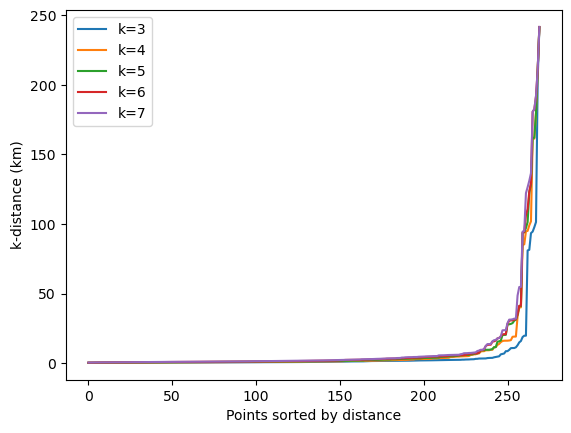

In [7]:
for k in [3,4,5,6,7]:
    nn = NearestNeighbors(n_neighbors=k, metric='haversine')
    nn.fit(coords_rad)
    dist_rad, _ = nn.kneighbors(coords_rad)
    kdist_km = np.sort(dist_rad[:, -1]) * EARTH_R
    plt.plot(kdist_km, label=f'k={k}')

plt.ylabel("k-distance (km)")
plt.xlabel("Points sorted by distance")
plt.legend()
plt.show()


The k-distance plot for values of k ranging from 3 to 7 shows that most stations have very small nearest-neighbor distances, forming a long flat section in the curve. This indicates that the majority of stations are located in dense clusters with minimal separation. Toward the right-hand side of the plot, there is a sharp increase in k-distance, suggesting that a small number of stations are geographically isolated from the main cluster and could represent outliers or edge cases.

Importantly, the “elbow” in the curve is consistent across different values of k, appearing in the range of approximately 40–60 km. From the figure above, we should consider the k number between 4 to 6, as this range balances cluster density and stability and the curve increase significant first. This elbow point also provides a useful guideline for selecting the eps parameter in DBSCAN, as it captures the dense clusters while excluding distant, sparsely connected stations. Overall, the analysis confirms a strong core group of stations with a few outliers, making density-based clustering a suitable approach for this dataset.

In [8]:
from numpy import percentile
results = []
for k in [4,5,6]:
    nn = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', metric='haversine')
    nn.fit(coords_rad)
    dist_rad, _ = nn.kneighbors(coords_rad)
    kdist_km = np.sort(dist_rad[:, -1]) * EARTH_R

    for q in [70,75,80,85,90]:
        eps_km = float(percentile(kdist_km, q))
        eps_rad = eps_km / EARTH_R
        db = DBSCAN(eps=eps_rad, min_samples=k, metric='haversine', algorithm='ball_tree')
        labels = db.fit_predict(coords_rad)
        n_clusters = len(set(labels) - {-1})
        noise_pct = (labels == -1).mean() * 100
        results.append((k, q, eps_km, n_clusters, noise_pct))

res_df = pd.DataFrame(results, columns=['k','percentile','eps_km','n_clusters','noise_pct'])
print(res_df.sort_values(['k','percentile']))


    k  percentile     eps_km  n_clusters  noise_pct
0   4          70   2.321035          12  25.185185
1   4          75   2.901352          13  21.111111
2   4          80   3.916660           9  17.407407
3   4          85   5.854658           5  13.333333
4   4          90  11.401549           4   9.259259
5   5          70   3.016420          11  25.925926
6   5          75   3.675250          10  21.851852
7   5          80   4.806767           8  16.296296
8   5          85   6.299661           5  13.333333
9   5          90  11.404056           4   9.259259
10  6          70   3.560404          10  27.037037
11  6          75   4.456120          11  18.148148
12  6          80   5.393466           7  15.555556
13  6          85   6.811065           5  13.333333
14  6          90  15.688060           4   8.888889


The DBSCAN parameter tuning results show how different combinations of nearest neighbours and distance percentiles influence the eps value, number of clusters, and proportion of noise points. In other words, lower percentiles lead to smaller eps values, producing more clusters and increasing the percentage of noise, while higher percentiles increase eps, which reduces the number of clusters and risks merging distinct groups. According to the table above, for k = 6 and percentile = 85, the results give an eps of approximately 6.81 km, which proves that 7 well-defined clusters with only 13.3% noise points. This shows a good balance between preserving the natural cluster structure and limiting the amount of noise, without collapsing clusters into overly broad groups as seen at higher percentiles. Therefore, the choice of k = 6 and percentile = 85 is appropriate for clustering stations and ensuring the stability of the model.

In [9]:
# DBSCAN clustering of stations based on geographic coordinates
# after finalizing eps_km
db = DBSCAN(
    eps=6.811065 / EARTH_R,
    min_samples=6,
    metric='haversine',
    algorithm='ball_tree',
    n_jobs=-1
)
station_locs['geo_cluster'] = db.fit_predict(coords_rad)

# Statistics
stats = station_locs['geo_cluster'].value_counts().rename_axis('cluster').to_frame('n_stations')
n_clusters = (stats.loc[stats.index != -1]).shape[0]
total = int(stats['n_stations'].sum())
noise = int(stats.loc[-1, 'n_stations']) if -1 in stats.index else 0
print(stats.sort_index())
print(f'Total stations: {total} | Valid clusters: {n_clusters} | Noise: {noise} ({noise/total:.1%})')

# Assign clusters back to the daily dataframe
df = clean_data.merge(station_locs[['station_id', 'geo_cluster']], on='station_id', how='left')


         n_stations
cluster            
-1               36
 0               29
 1               10
 2               10
 3              174
 4               11
Total stations: 270 | Valid clusters: 5 | Noise: 36 (13.3%)


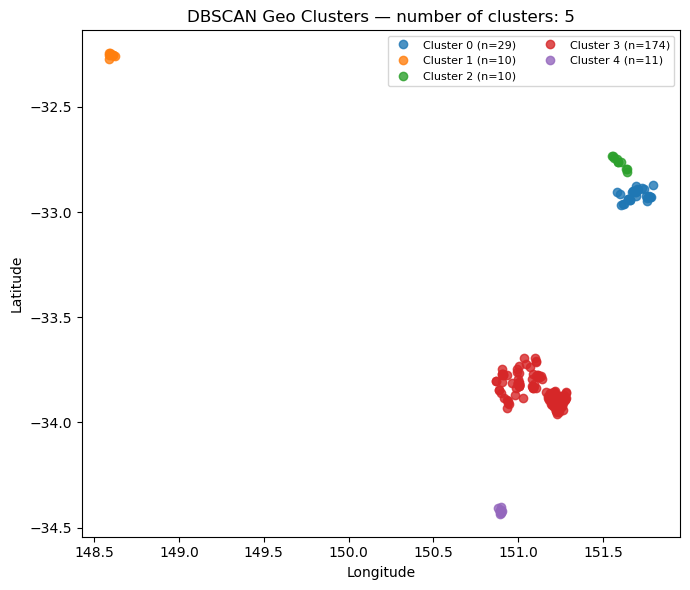

In [10]:
# Visualization: Plot DBSCAN geographic clusters of stations
labels = station_locs['geo_cluster'].to_numpy()
X = station_locs[['Longitude', 'Latitude']].to_numpy()

show_noise = False

# Number of clusters (excluding noise = -1)
unique_labels = sorted(set(labels))
n_clusters_ = len([k for k in unique_labels if k != -1])

plt.figure(figsize=(7,6))

for k in unique_labels:
    if k == -1:
        if not show_noise:
            continue
        mask = (labels == -1)
        xy = X[mask]
        if len(xy) > 0:
            plt.plot(
                xy[:,0], xy[:,1], 'x', ms=6, alpha=0.6,
                label=f'Noise (n={len(xy)})'
            )
    else:
        mask = (labels == k)
        xy = X[mask]
        if len(xy) > 0:
            # Each cluster is drawn with dots (no distinction between core/border points)
            plt.plot(
                xy[:,0], xy[:,1], 'o', ms=6, alpha=0.8,
                label=f'Cluster {k} (n={len(xy)})'
            )

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'DBSCAN Geo Clusters — number of clusters: {n_clusters_}')
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542160 entries, 0 to 542159
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  542160 non-null  object 
 1   station_id            542160 non-null  int64  
 2   Station name          542160 non-null  object 
 3   Number of station     542160 non-null  float64
 4   Number of plugs       542160 non-null  float64
 5   Latitude              542160 non-null  float64
 6   Longitude             542160 non-null  float64
 7   day_of_week           542160 non-null  float64
 8   public_holiday        542160 non-null  float64
 9   school_holiday        542160 non-null  float64
 10  Avg_Temp              542160 non-null  float64
 11  Avg_Humidity          542160 non-null  float64
 12  Avg_Wind              542160 non-null  float64
 13  is_weekend            542160 non-null  float64
 14  daily_total           542160 non-null  float64
 15  

In [12]:
# Convert the date column into the right data type
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

### Visualising clusters over NSW

In [13]:
# Draw map to see the cluster better
# Approximate NSW bounds
NSW_LAT_MIN, NSW_LAT_MAX = -37.5, -28.0
NSW_LON_MIN, NSW_LON_MAX = 141.0, 153.8

# station_locs: must contain Latitude, Longitude, geo_cluster, (optional) station_id, Station name
clusters = sorted([int(c) for c in station_locs['geo_cluster'].unique() if c != -1]) \
           + ([-1] if (-1 in station_locs['geo_cluster'].unique()) else [])
cmap = plt.cm.get_cmap('tab20', max(1, len([c for c in clusters if c != -1])))

def color_of(clu):
    if clu == -1:
        return '#7f7f7f'
    idx = [c for c in clusters if c != -1].index(clu)
    r, g, b, a = cmap(idx)
    return '#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255))

# Base map: OpenStreetMap (same background as your screenshot)
nsw_center = (-32.5, 147.0)
m = folium.Map(location=nsw_center, zoom_start=6, control_scale=True, tiles='OpenStreetMap')

# Plot stations by cluster
for clu in clusters:
    fg = folium.FeatureGroup(name=f'cluster {clu}', show=(clu != -1))
    mc = MarkerCluster(disableClusteringAtZoom=15)
    color = color_of(clu)

    sub = station_locs[station_locs['geo_cluster'] == clu]
    for _, r in sub.iterrows():
        lat, lon = float(r['Latitude']), float(r['Longitude'])
        sid = r.get('station_id', 'N/A')
        name = r.get('Station name', r.get('Station_name', 'N/A'))
        folium.CircleMarker(
            location=(lat, lon),
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.9,
            tooltip=f"{name} (ID: {sid}) — cluster {clu}",
            popup=folium.Popup(
                f"<b>Station:</b> {name}<br><b>ID:</b> {sid}<br>"
                f"<b>Cluster:</b> {clu}<br><b>Lat/Lon:</b> {lat:.5f}, {lon:.5f}",
                max_width=280
            )
        ).add_to(mc)
    mc.add_to(fg)
    fg.add_to(m)

# Fit bounds to data (fallback to NSW bounds if dataset is empty)
if len(station_locs):
    lat_min, lat_max = station_locs['Latitude'].min(), station_locs['Latitude'].max()
    lon_min, lon_max = station_locs['Longitude'].min(), station_locs['Longitude'].max()
    pad_lat = (lat_max - lat_min) * 0.05 if lat_max > lat_min else 0.1
    pad_lon = (lon_max - lon_min) * 0.05 if lon_max > lon_min else 0.1
    m.fit_bounds([[lat_min - pad_lat, lon_min - pad_lon],
                  [lat_max + pad_lat, lon_max + pad_lon]])
else:
    m.fit_bounds([[NSW_LAT_MIN, NSW_LON_MIN], [NSW_LAT_MAX, NSW_LON_MAX]])

# Map utilities + LayerControl (only one base layer = OSM)
MiniMap(toggle_display=True).add_to(m)
Fullscreen().add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

# Save map to HTML and display
m.save("nsw_clusters.html")
print("Saved: nsw_clusters.html")
# show inline in Colab / Jupyter
m


Saved: nsw_clusters.html


### Plotting EV demand in kWh by cluster

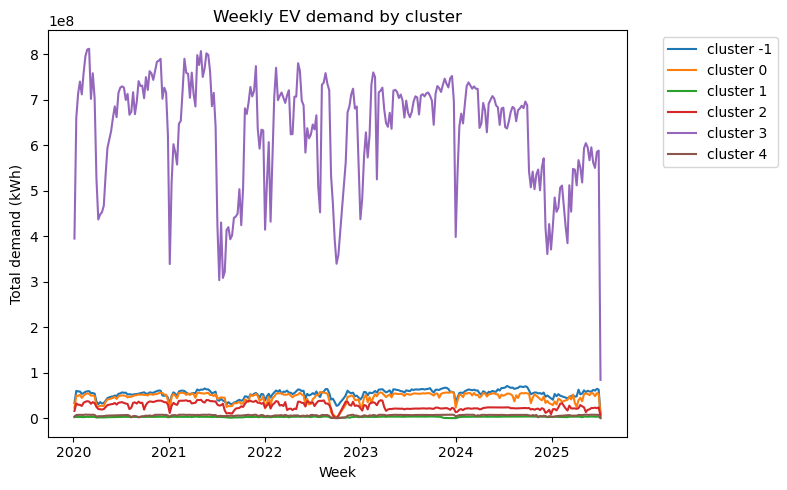

In [14]:
weekly = (df
          .set_index('Date')
          .groupby('geo_cluster')['estimated_demand_kWh']
          .resample('W').sum()
          .reset_index())

plt.figure(figsize=(8,5))
for clu, g in weekly.groupby('geo_cluster'):
    plt.plot(g['Date'], g['estimated_demand_kWh'], label=f'cluster {clu}')

plt.xlabel("Week")
plt.ylabel("Total demand (kWh)")
plt.title("Weekly EV demand by cluster")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


The DBSCAN geo clustering results reveal five distinct clusters of stations, each varying in size and geographic concentration. The largest cluster (cluster 3) contains 174 stations and is densely concentrated around the Sydney metropolitan area, reflecting the city’s role as the primary demand hub.

Medium-sized clusters, such as clusters 0 and 2, consist of about 10–29 stations each and represent smaller but still locally dense regions. 

In contrast, clusters 1 and 4 are much smaller, with only 10–11 stations, indicating isolated or regional coverage areas outside the urban core.

The clusters are well separated spatially, showing minimal overlap, which highlights the algorithm’s ability to distinguish between urban and regional demand zones. From a practical standpoint, this distribution suggests that while the majority of demand will be concentrated in the largest urban cluster, the smaller clusters represent secondary zones that may either be underserved or in need of targeted infrastructure planning. If outliers were displayed, they would likely correspond to isolated stations in remote areas, requiring unique treatment in demand forecasting. Overall, the clustering provides clear insights into station density and regional distribution, supporting strategic decisions for both capacity management and network expansion

The spatial separation between clusters is clear, with minimal overlap, demonstrating DBSCAN’s effectiveness in distinguishing urban demand zones from regional or remote areas. Strategically, this distribution suggests that while the bulk of demand will be concentrated in the Sydney cluster, the smaller peripheral clusters highlight secondary demand areas. These may require tailored infrastructure planning—either to expand coverage in underserved regions or to manage growth in emerging hotspots.

In [15]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542160 entries, 0 to 542159
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  542160 non-null  datetime64[ns]
 1   station_id            542160 non-null  int64         
 2   Station name          542160 non-null  object        
 3   Number of station     542160 non-null  float64       
 4   Number of plugs       542160 non-null  float64       
 5   Latitude              542160 non-null  float64       
 6   Longitude             542160 non-null  float64       
 7   day_of_week           542160 non-null  float64       
 8   public_holiday        542160 non-null  float64       
 9   school_holiday        542160 non-null  float64       
 10  Avg_Temp              542160 non-null  float64       
 11  Avg_Humidity          542160 non-null  float64       
 12  Avg_Wind              542160 non-null  float64       
 13 

In [16]:
# Create the external factor list
cand_exog = ['public_holiday','school_holiday','Avg_Temp','Avg_Humidity','Avg_Wind','is_weekend']
exog_cols  = [c for c in cand_exog if c in df.columns]


In [17]:
# Convert the date column into the right data type
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [18]:
# Check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542160 entries, 0 to 542159
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  542160 non-null  datetime64[ns]
 1   station_id            542160 non-null  int64         
 2   Station name          542160 non-null  object        
 3   Number of station     542160 non-null  float64       
 4   Number of plugs       542160 non-null  float64       
 5   Latitude              542160 non-null  float64       
 6   Longitude             542160 non-null  float64       
 7   day_of_week           542160 non-null  float64       
 8   public_holiday        542160 non-null  float64       
 9   school_holiday        542160 non-null  float64       
 10  Avg_Temp              542160 non-null  float64       
 11  Avg_Humidity          542160 non-null  float64       
 12  Avg_Wind              542160 non-null  float64       
 13 

In [19]:
# Group the data by geo_cluster and date
df_group = df.groupby(['geo_cluster','Date'], as_index=True)
df_group.head(5)

Date  station_id             Station name  Number of station  \
0      2020-01-01          61          Mackellar Motel                2.0   
1      2020-01-02          61          Mackellar Motel                2.0   
2      2020-01-03          61          Mackellar Motel                2.0   
3      2020-01-04          61          Mackellar Motel                2.0   
4      2020-01-05          61          Mackellar Motel                2.0   
...           ...         ...                      ...                ...   
524083 2025-06-26         823  1 Georges Place Parking                1.0   
524084 2025-06-27         823  1 Georges Place Parking                1.0   
524085 2025-06-28         823  1 Georges Place Parking                1.0   
524086 2025-06-29         823  1 Georges Place Parking                1.0   
524087 2025-06-30         823  1 Georges Place Parking                1.0   

        Number of plugs   Latitude   Longitude  day_of_week  public_holiday  \
0                   2.0 -30.980048  150.257659          3.0             0.0   
1                   2.0 -30.980048  150.257659          4.0             0.0   
2                   2.0 -30.980048  150.257659          5.0             0.0   
3                   2.0 -30.980048  150.257659          6.0             0.0   
4                   2.0 -30.980048  150.257659          7.0             0.0   
...                 ...        ...         ...          ...             ...   
524083              2.0 -34.418637  150.902172          4.0             0.0   
524084              2.0 -34.418637  150.902172          5.0             0.0   
524085              2.0 -34.418637  150.902172          6.0             0.0   
524086              2.0 -34.418637  150.902172          7.0             0.0   
524087              2.0 -34.418637  150.902172          1.0             0.0   

        school_holiday  Avg_Temp  Avg_Humidity  Avg_Wind  is_weekend  \
0                  1.0     22.43         70.00     20.96         0.0   
1                  1.0     22.43         70.00     20.96         0.0   
2                  1.0     24.80         73.50     18.02         0.0   
3                  1.0     30.10         54.04     27.47         1.0   
4                  1.0     22.28         66.84     34.90         1.0   
...                ...       ...           ...       ...         ...   
524083             0.0     11.02         53.69     26.18         0.0   
524084             0.0     11.98         67.96     19.42         0.0   
524085             0.0     12.90         74.27     10.93         1.0   
524086             0.0     12.81         75.27     11.29         1.0   
524087             0.0     13.08         77.08     17.31         0.0   

        daily_total  estimated_demand_kWh  geo_cluster  
0            1507.0              26464.81           -1  
1            1507.0              26464.81           -1  
2            1583.0              27640.15           -1  
3            2559.0              44002.65           -1  
4            2268.0              39050.06           -1  
...             ...                   ...          ...  
524083       6737.0             113848.07            4  
524084       6563.0             110921.29            4  
524085       4975.0              83743.11            4  
524086       4015.0              67399.05            4  
524087       6023.0             101883.19            4  

[60240 rows x 17 columns]

In [20]:
# Create a function to create a daily time series frame aggregated by geo_cluster and Date
def make_daily_frame(df_group, y_col, exog_cols, freq='D'):
    # Create aggregation dictionary
    agg = {y_col: 'sum'}
    for c in exog_cols:
        if c in ['public_holiday', 'school_holiday', 'is_weekend']:
            agg[c] = 'max'
        else:
            agg[c] = 'mean'

    # Group by geo_cluster and Date
    g_daily = (df_group.groupby(['geo_cluster', 'Date'], as_index=True)
                        .agg(agg)
                        .sort_index())

    out_list = []
    for cid, g in g_daily.groupby(level=0):   # for each geo_cluster
        # Set Date as DatetimeIndex
        g = g.droplevel(0).sort_index()       # index = Date
        g = g.sort_index()

        # Create full date range to reindex
        full_idx = pd.date_range(g.index.min(), g.index.max(), freq=freq)

        # Target variable y
        y = g[[y_col]].reindex(full_idx).asfreq(freq).fillna(0.0)

        # Exogenous variables X
        if exog_cols:
            # only keep exog columns that still exist after aggregation
            exog_present = [c for c in exog_cols if c in g.columns]
            X = g[exog_present].reindex(full_idx).asfreq(freq)
            # fill missing exog values with forward/backward fill
            X = X.ffill().bfill()
            out = pd.concat([y, X], axis=1)
        else:
            out = y

        out.index.name = 'Date'
        out['geo_cluster'] = cid
        out_list.append(out)

    # Combine results: includes Date + geo_cluster
    result = pd.concat(out_list).reset_index()
    return result


In [21]:
geo_data = make_daily_frame(df, 'estimated_demand_kWh', exog_cols)
geo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12048 entries, 0 to 12047
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  12048 non-null  datetime64[ns]
 1   estimated_demand_kWh  12048 non-null  float64       
 2   public_holiday        12048 non-null  float64       
 3   school_holiday        12048 non-null  float64       
 4   Avg_Temp              12048 non-null  float64       
 5   Avg_Humidity          12048 non-null  float64       
 6   Avg_Wind              12048 non-null  float64       
 7   is_weekend            12048 non-null  float64       
 8   geo_cluster           12048 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 847.3 KB


In [22]:
geo_data.head(5)

Date  estimated_demand_kWh  public_holiday  school_holiday   Avg_Temp  \
0 2020-01-01            6961596.71             0.0             1.0  22.212222   
1 2020-01-02            6097220.65             0.0             1.0  22.678611   
2 2020-01-03            6768273.57             0.0             1.0  24.792778   
3 2020-01-04            6564854.03             0.0             1.0  29.069444   
4 2020-01-05            7175393.52             0.0             1.0  22.412778   

   Avg_Humidity   Avg_Wind  is_weekend  geo_cluster  
0     70.291667  22.471667         0.0           -1  
1     69.972222  20.998333         0.0           -1  
2     72.819444  18.131667         0.0           -1  
3     56.232778  26.944444         1.0           -1  
4     66.529444  34.073889         1.0           -1

In [23]:
geo_data = geo_data.set_index("Date").sort_index()
geo_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12048 entries, 2020-01-01 to 2025-06-30
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   estimated_demand_kWh  12048 non-null  float64
 1   public_holiday        12048 non-null  float64
 2   school_holiday        12048 non-null  float64
 3   Avg_Temp              12048 non-null  float64
 4   Avg_Humidity          12048 non-null  float64
 5   Avg_Wind              12048 non-null  float64
 6   is_weekend            12048 non-null  float64
 7   geo_cluster           12048 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 847.1 KB


### Plot estimated demand and outliers for each cluster

Cluster 0 | Lower bound: 1776050.38, Upper bound: 12154360.78
Outliers detected: 100


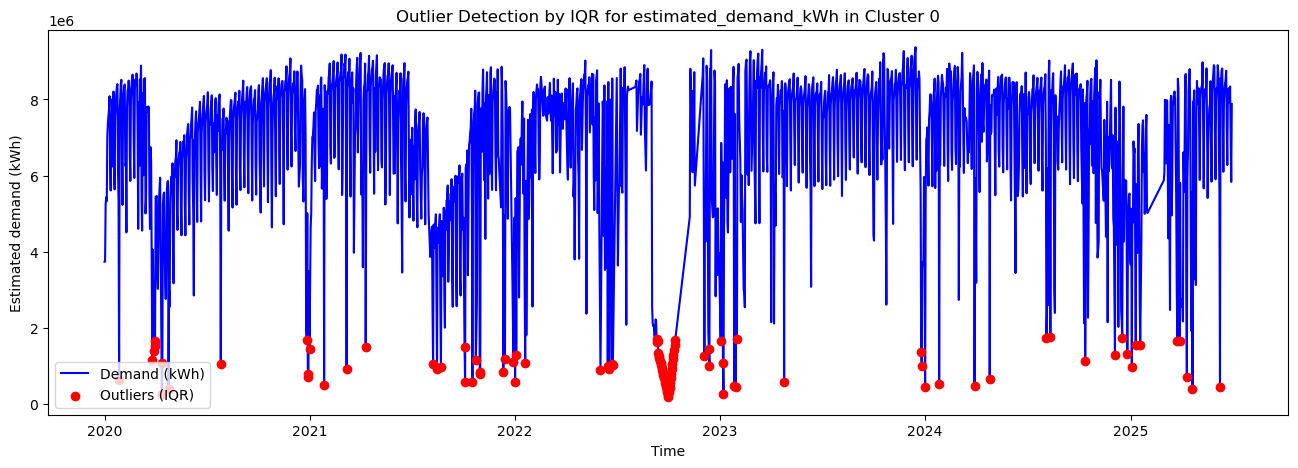

Cluster 1 | Lower bound: 110764.32, Upper bound: 818985.93
Outliers detected: 44


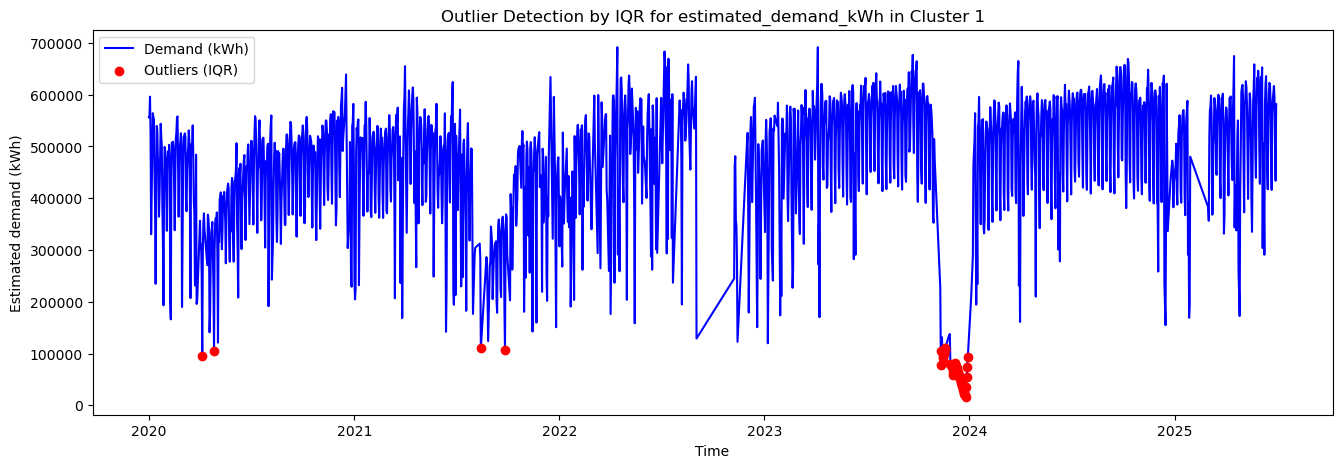

Cluster 2 | Lower bound: -239832.75, Upper bound: 8149160.16
Outliers detected: 0


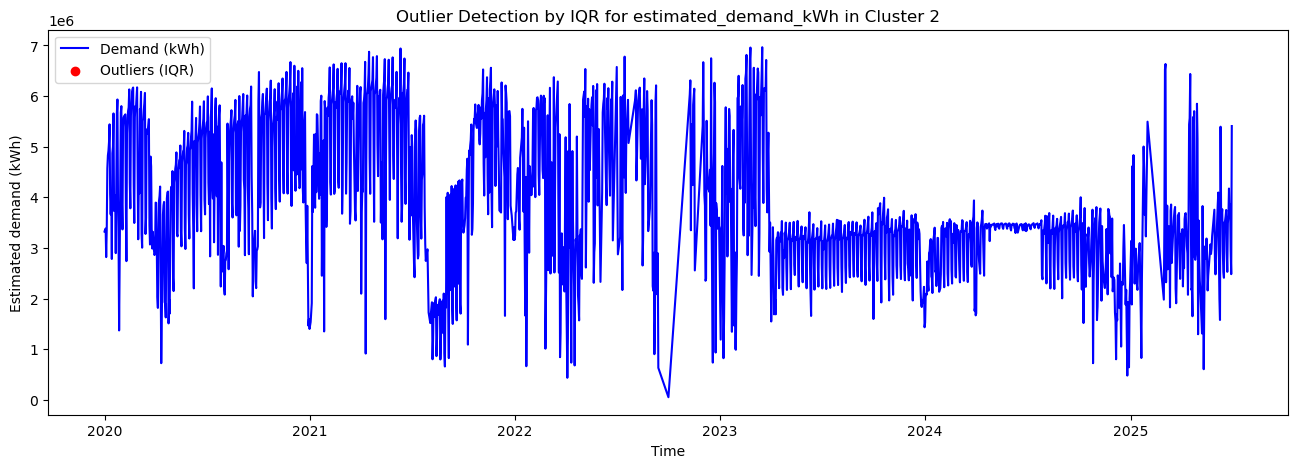

Cluster 3 | Lower bound: 31596636.86, Upper bound: 152340805.84
Outliers detected: 7


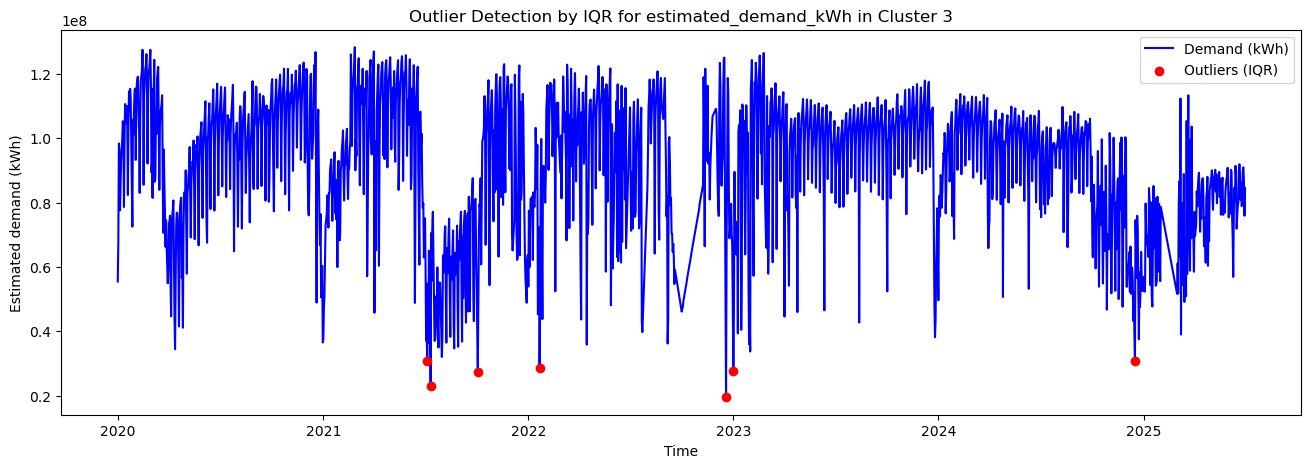

Cluster 4 | Lower bound: 155860.67, Upper bound: 1791797.93
Outliers detected: 48


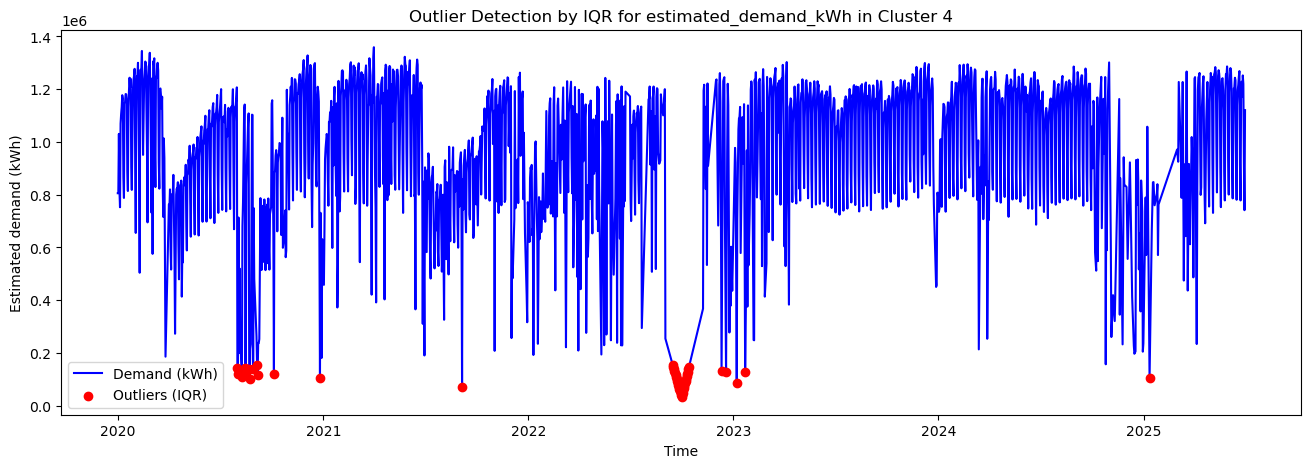

In [24]:
# Keep the same cluster range
geo_number = range(0, 5)

# Initialize outlier flag
geo_data['is_outlier'] = False

for i in geo_number:
    # Create mask index for cluster i
    idx = (geo_data['geo_cluster'] == i)

    # Get view by mask and copy for safe calculation (avoid chained assignment)
    df = geo_data.loc[idx].copy()

    # Detect outliers by IQR
    Q1 = df['estimated_demand_kWh'].quantile(0.25)
    Q3 = df['estimated_demand_kWh'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Compute outlier mask on df (copy)
    mask_out = (df['estimated_demand_kWh'] < lower_bound) | (df['estimated_demand_kWh'] > upper_bound)

    # CWrite results directly back into geo_data using .loc
    geo_data.loc[idx, 'is_outlier'] = mask_out.values

    # Extract outliers from geo_data for printing & plotting
    outliers = geo_data.loc[idx & geo_data['is_outlier']]

    print(f"Cluster {i} | Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    print(f"Outliers detected: {len(outliers)}")

    # Plot
    plt.figure(figsize=(16, 5))
    plt.plot(df.index, df['estimated_demand_kWh'], label="Demand (kWh)", color="blue")
    plt.scatter(outliers.index, outliers['estimated_demand_kWh'], color="red", label="Outliers (IQR)", zorder=5)
    plt.title(f"Outlier Detection by IQR for estimated_demand_kWh in Cluster {i}")
    plt.xlabel("Time")
    plt.ylabel("Estimated demand (kWh)")
    plt.legend()
    plt.show()


In [25]:
geo_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12048 entries, 2020-01-01 to 2025-06-30
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   estimated_demand_kWh  12048 non-null  float64
 1   public_holiday        12048 non-null  float64
 2   school_holiday        12048 non-null  float64
 3   Avg_Temp              12048 non-null  float64
 4   Avg_Humidity          12048 non-null  float64
 5   Avg_Wind              12048 non-null  float64
 6   is_weekend            12048 non-null  float64
 7   geo_cluster           12048 non-null  int64  
 8   is_outlier            12048 non-null  bool   
dtypes: bool(1), float64(7), int64(1)
memory usage: 858.9 KB


#### Remove outliers

In [26]:
def fix_outliers(g):
    # Build masks
    mask_event = (g['school_holiday'] == 1) | (g['public_holiday'] == 1) | (g['is_weekend'] == 1)
    mask_sensor_error = g['is_outlier'].astype(bool) & (~mask_event)

    # Work on a float copy of the target series
    s = g['estimated_demand_kWh'].astype(float)

    # Blank out the outliers so interpolation has something to fill
    s.loc[mask_sensor_error] = np.nan

    # Interpolate by time; fill edges as well
    s = s.interpolate(method='time', limit_direction='both')

    # Write back
    g['estimated_demand_kWh'] = s

    # Return original shape
    return g.reset_index()

# apply per-geo group; drop the flag after fixing
geo_clean = (
    geo_data
    .groupby("geo_cluster", group_keys=False)
    .apply(fix_outliers)
    .drop(columns=['is_outlier'])
)


### Plot estimated demand for each cluster using data with outliers removed

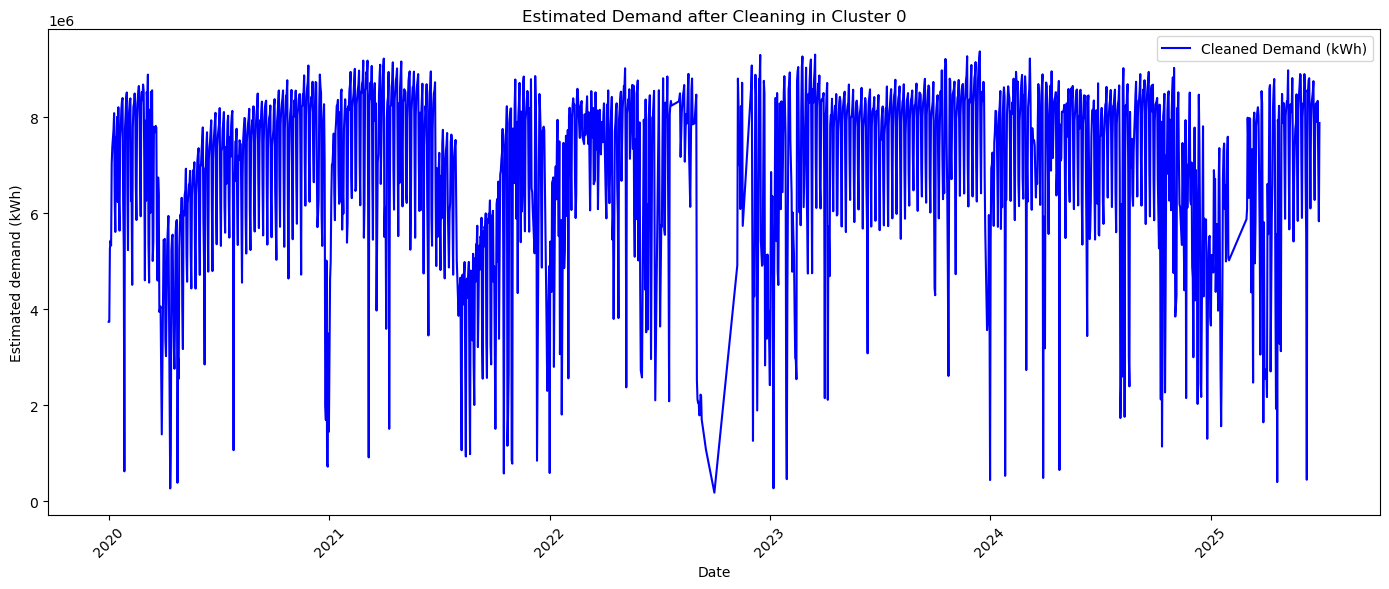

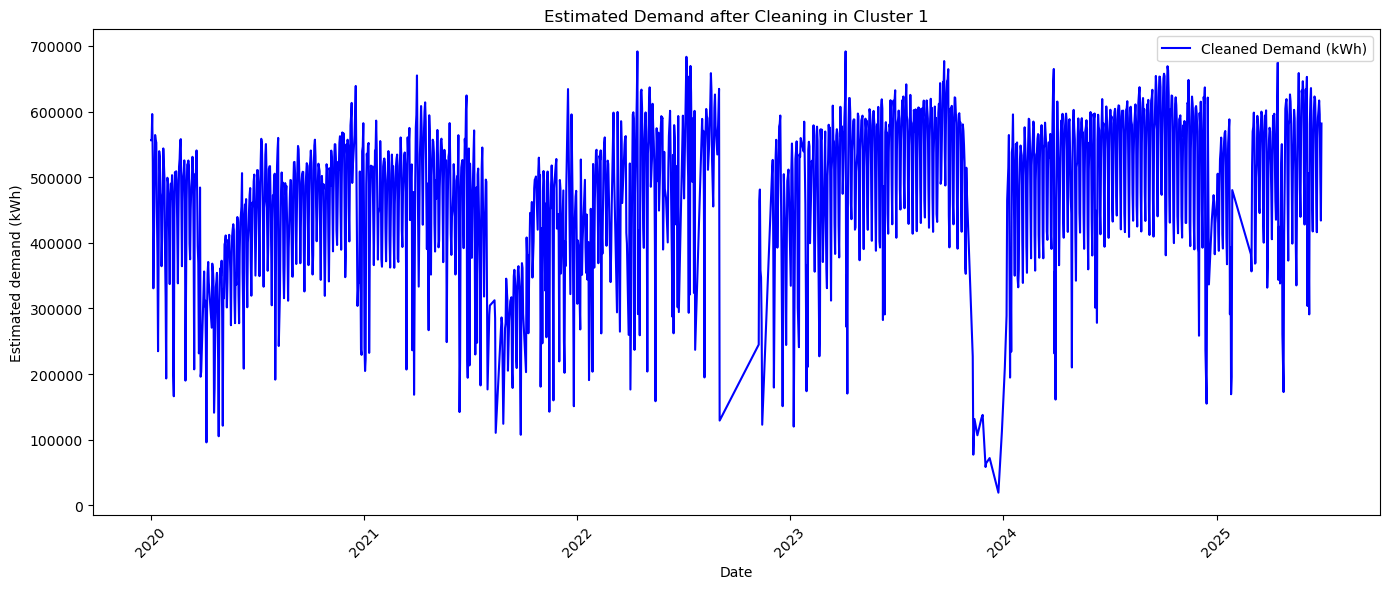

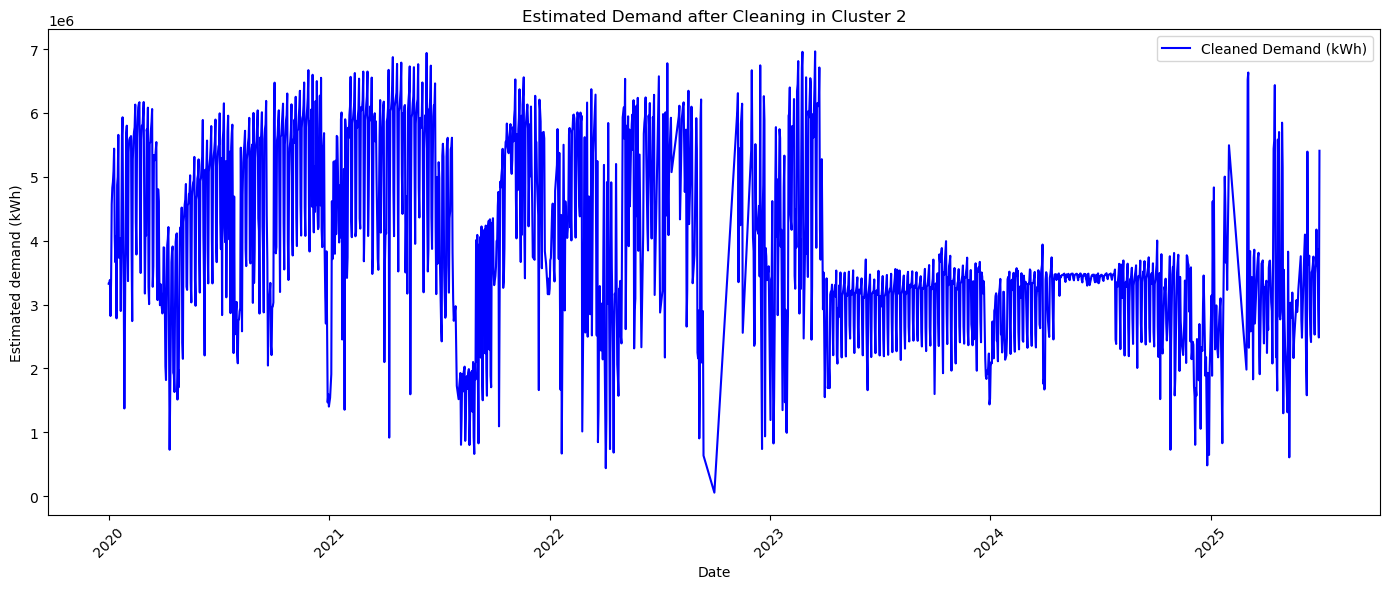

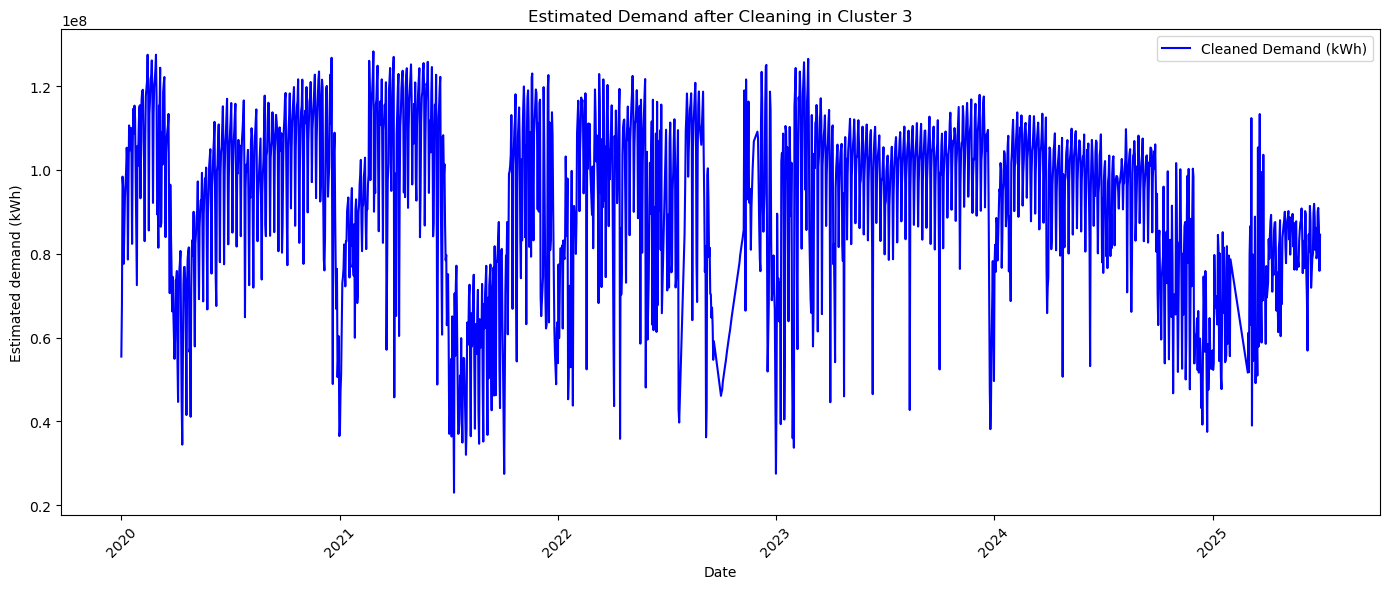

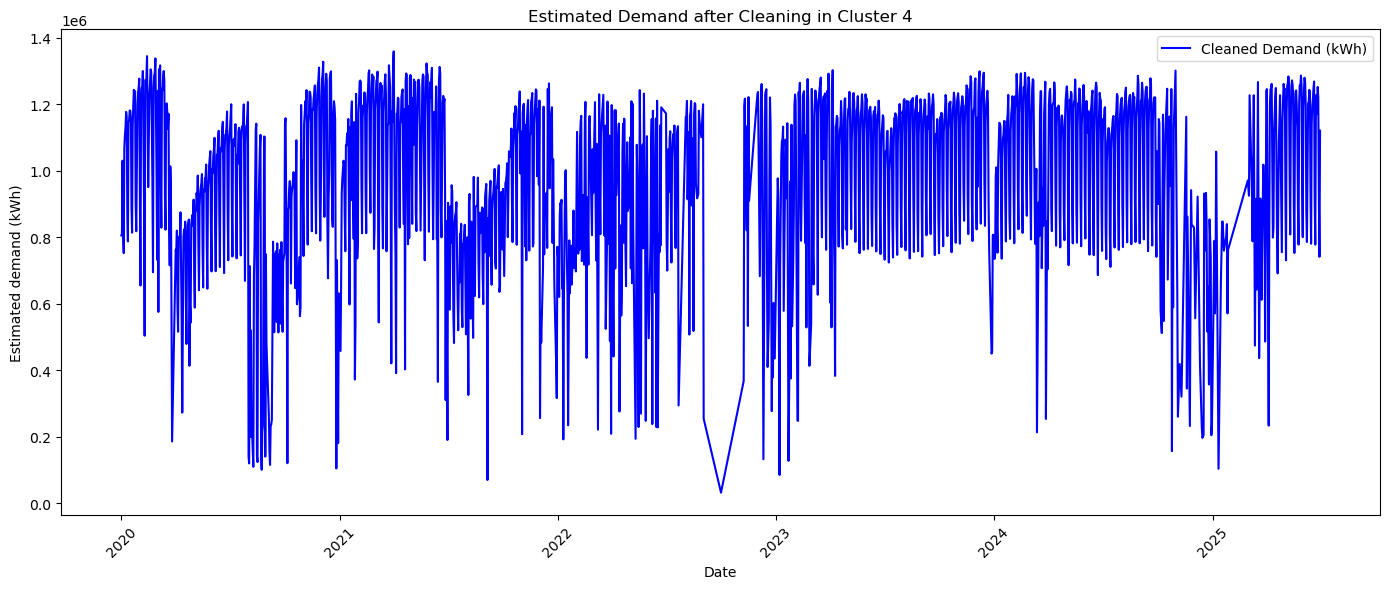

In [27]:
# Ensure Date is datetime
geo_clean['Date'] = pd.to_datetime(geo_clean['Date'])
geo_clean = geo_clean.sort_values(['geo_cluster', 'Date'])

for i in geo_number:
    # Filter cluster i
    df = geo_clean.loc[geo_clean['geo_cluster'] == i].copy()

    plt.figure(figsize=(14, 6))
    plt.plot(df['Date'], df['estimated_demand_kWh'], label="Cleaned Demand (kWh)", color="blue")

    plt.title(f"Estimated Demand after Cleaning in Cluster {i}")
    plt.xlabel("Date")
    plt.ylabel("Estimated demand (kWh)")
    plt.legend()

    # Format x-axis
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [28]:
# Check data type
geo_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12048 entries, 0 to 2007
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  12048 non-null  datetime64[ns]
 1   estimated_demand_kWh  12048 non-null  float64       
 2   public_holiday        12048 non-null  float64       
 3   school_holiday        12048 non-null  float64       
 4   Avg_Temp              12048 non-null  float64       
 5   Avg_Humidity          12048 non-null  float64       
 6   Avg_Wind              12048 non-null  float64       
 7   is_weekend            12048 non-null  float64       
 8   geo_cluster           12048 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 941.2 KB


### Check if time series data is stationary using Augmented Dickey-Fuller (ADF) test
We will check for seasonality in each cluster using an ADF test, and print the results.

In [29]:
def perform_adf_test(data):
    # Perform ADF test
    result = adfuller(data)

    # Print the results
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Check if the data is stationary based on the p-value
    if result[1] <= 0.05:
        print("The data is stationary")
    else:
        print("The data is not stationary, Data can be processed further")

for i in geo_number:
  print(f"Geo Cluster {i}")
  perform_adf_test(geo_clean[geo_clean['geo_cluster'] == i]['estimated_demand_kWh'])
  print("------------------")

Geo Cluster 0
ADF Statistic: -4.751739621684895
p-value: 6.72062197764452e-05
Critical Values: {'1%': np.float64(-3.4336502927748587), '5%': np.float64(-2.8629978852039737), '10%': np.float64(-2.5675461168480913)}
The data is stationary
------------------
Geo Cluster 1
ADF Statistic: -4.393748621889852
p-value: 0.0003044862002833094
Critical Values: {'1%': np.float64(-3.433648628001351), '5%': np.float64(-2.8629971502062155), '10%': np.float64(-2.5675457254979093)}
The data is stationary
------------------
Geo Cluster 2
ADF Statistic: -4.286839986817792
p-value: 0.0004681082409740728
Critical Values: {'1%': np.float64(-3.433645303487856), '5%': np.float64(-2.8629956824317757), '10%': np.float64(-2.5675449439803617)}
The data is stationary
------------------
Geo Cluster 3
ADF Statistic: -4.4341652992655005
p-value: 0.0002581242963551974
Critical Values: {'1%': np.float64(-3.433648628001351), '5%': np.float64(-2.8629971502062155), '10%': np.float64(-2.5675457254979093)}
The data is stati

Since the resulting p-value of each cluster was less than 0.05, we conclude that the data is **stationary** for all clusters.

## Build GRU Model for EV Charging Demand Prediction

Create the function to split the training and testing dataset

In [30]:
start = 2020
end = 2023

def time_split(df, start_year, end_year):
    train_df = df.loc[f"{start_year}":f"{end_year}"]
    test_df  = df.loc[f"{end_year+1}":]
    return train_df, test_df

Create the function to split x_train, y_train, x_test, y_test

In [31]:
def split_sequence(sequence, n_steps, forecasting_horizon, y_index):
    X, y = list(), list()
    for i in range(len(sequence)):
      end_ix = i + n_steps
      if end_ix > len(sequence)-forecasting_horizon:
        break
      seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon, y_index]
      X.append(seq_x)
      y.append(seq_y)
    return np.array(X), np.array(y)

Create the function to calculate the evaluation metrics

In [32]:
def return_metrics(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  rmse = root_mean_squared_error(y_true, y_pred)
  print("MAE: {:.2f}".format(mae))
  print("MAPE: {:.2%}".format(mape))
  print("RMSE: {:2f}".format(rmse))
  return mae, mape, rmse

### Implement the  Gated Recurrent Unit (GRU) model

Load libraries

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

Train the models

In [34]:
GRU_result ={}

for i in geo_number:
  df = geo_clean[geo_clean['geo_cluster'] == i]
  df = df.drop(columns=['geo_cluster'])
  df.set_index('Date', inplace= True)


  #Split the trainning and testing dataset
  training_set, test_set = time_split(df, start, end)

  #Save the train
  training_set_shape = training_set.shape
  test_set_shape = test_set.shape

  #Import the min_max scaller
  sc = MinMaxScaler(feature_range =(0,1))

  #Reshape training_set
  training_set = training_set.values.reshape(-1,1)
  training_set_scaled = sc.fit_transform(training_set)
  training_set_scaled = training_set_scaled.reshape(training_set_shape[0], test_set_shape[1])

  #Parameter prepare for the model
  n_steps = 50
  forecasting_horizon = 14
  features = 7
  y_index = 0

  #Split the X_train and y_train for model
  X_train, y_train = split_sequence(training_set_scaled, n_steps, forecasting_horizon, y_index)

  #Reshaping Y_train for model
  y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

  #Set the gru_model
  model_gru = Sequential()
  model_gru.add(GRU(units=128,activation="tanh", return_sequences=False, input_shape=(n_steps, features)))
  model_gru.add(Dropout(0.2))
  model_gru.add(Dense(units=14))
  model_gru.compile(optimizer=Adamax(learning_rate=0.001), loss='mean_squared_error')

  #Set the early stop
  early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=True)
  model_gru.fit(X_train, y_train, epochs=200, batch_size=64, verbose=0, callbacks=[early_stop])

  #Set the RNN testing
  input_values = test_set.values.reshape(-1,1)
  input_values = sc.transform(input_values)
  input_values = input_values.reshape(test_set_shape[0], test_set_shape[1])

  #Split the X_test and y_test
  X_test, y_test = split_sequence(input_values, n_steps, forecasting_horizon, y_index)

  #Predict the values
  predict_EV_demand = model_gru.predict(X_test)
  predict_EV_demand = sc.inverse_transform(predict_EV_demand)

  #Inverst the testing values
  y_test = y_test.reshape(y_test.shape[0],y_test.shape[1])
  y_test = sc.inverse_transform(y_test)


  GRU_result[i] = {
      "model" : model_gru,
      "predict_EV_demand": predict_EV_demand,
      "y_test" : y_test,
  }



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step 


Evaluate the models

In [35]:
best_GRU_result = {}

for geo_id, res in GRU_result.items():
    y_true = res["y_test"]
    y_pred = res["predict_EV_demand"]
    horizon = min(y_true.shape[1], y_pred.shape[1])

    # Initialize the best result for this geo_id
    best_for_geo = {
        "horizon": None,
        "mape": float("inf"),
        "mae": None,
        "rmse": None,
        "model": None,
        "y_test": None,
        "y_pred": None,
        "dates": None
    }

    print(f"\nGeo_id: {geo_id}")
    for i in range(horizon):
        mae, mape, rmse = return_metrics(y_true[:, i], y_pred[:, i])
        print(f"Horizon {i} | MAE={mae:.2f}, MAPE={mape:.2%}, RMSE={rmse:.2f}")

        # Update if MAPE is smaller than the current best for this geo_id
        if mape < best_for_geo["mape"]:
            best_for_geo = {
                "horizon": i,
                "mape": mape,
                "mae": mae,
                "rmse": rmse,
                "model": res["model"],
                "y_test": y_true[:, i],
                "y_pred": y_pred[:, i],
                "dates": res["y_test"]
            }

    # Save the best result for this geo_id
    best_GRU_result[geo_id] = best_for_geo
    print("------------------")



Geo_id: 0
MAE: 1085081.18
MAPE: 34.28%
RMSE: 1582290.082078
Horizon 0 | MAE=1085081.18, MAPE=34.28%, RMSE=1582290.08
MAE: 1184957.33
MAPE: 36.61%
RMSE: 1677702.296249
Horizon 1 | MAE=1184957.33, MAPE=36.61%, RMSE=1677702.30
MAE: 1178931.07
MAPE: 36.98%
RMSE: 1699543.155038
Horizon 2 | MAE=1178931.07, MAPE=36.98%, RMSE=1699543.16
MAE: 1180458.36
MAPE: 36.72%
RMSE: 1689415.121435
Horizon 3 | MAE=1180458.36, MAPE=36.72%, RMSE=1689415.12
MAE: 1173244.48
MAPE: 37.15%
RMSE: 1690097.614211
Horizon 4 | MAE=1173244.48, MAPE=37.15%, RMSE=1690097.61
MAE: 1139253.76
MAPE: 36.91%
RMSE: 1676801.829794
Horizon 5 | MAE=1139253.76, MAPE=36.91%, RMSE=1676801.83
MAE: 1113650.89
MAPE: 36.10%
RMSE: 1667868.658195
Horizon 6 | MAE=1113650.89, MAPE=36.10%, RMSE=1667868.66
MAE: 1186353.81
MAPE: 36.42%
RMSE: 1685858.454477
Horizon 7 | MAE=1186353.81, MAPE=36.42%, RMSE=1685858.45
MAE: 1221130.98
MAPE: 37.33%
RMSE: 1730081.640459
Horizon 8 | MAE=1221130.98, MAPE=37.33%, RMSE=1730081.64
MAE: 1222649.12
MAPE: 36.9

In [36]:
print('GRU Model')
print('------------------')
for geo_id, res in best_GRU_result.items():
    y_true = res['y_test']
    mean_val = y_true.mean()

    print(f"Geo_id: {geo_id}")
    print(f"Horizon: {res['horizon']}")
    print(f"MAPE: {res['mape']:.2%}")
    print(f"MAE:  {res['mae']:.2f}")
    print(f"RMSE: {res['rmse']:.2f}")
    print(f"Mean actual demand: {mean_val:.2f}")
    print(f"MAE / Mean = {res['mae']/mean_val:.2%}")
    print(f"RMSE / Mean = {res['rmse']/mean_val:.2%}")
    print("------------------")


GRU Model
------------------
Geo_id: 0
Horizon: 0
MAPE: 34.28%
MAE:  1085081.18
RMSE: 1582290.08
Mean actual demand: 6743081.73
MAE / Mean = 16.09%
RMSE / Mean = 23.47%
------------------
Geo_id: 1
Horizon: 0
MAPE: 10.86%
MAE:  45146.96
RMSE: 63654.30
Mean actual demand: 510747.71
MAE / Mean = 8.84%
RMSE / Mean = 12.46%
------------------
Geo_id: 2
Horizon: 0
MAPE: 21.28%
MAE:  489681.97
RMSE: 704408.43
Mean actual demand: 3145652.98
MAE / Mean = 15.57%
RMSE / Mean = 22.39%
------------------
Geo_id: 3
Horizon: 0
MAPE: 10.90%
MAE:  7809498.86
RMSE: 10933330.79
Mean actual demand: 84077940.61
MAE / Mean = 9.29%
RMSE / Mean = 13.00%
------------------
Geo_id: 4
Horizon: 0
MAPE: 19.99%
MAE:  121647.08
RMSE: 173049.75
Mean actual demand: 955759.17
MAE / Mean = 12.73%
RMSE / Mean = 18.11%
------------------


### Visually compare predicted vs actual values

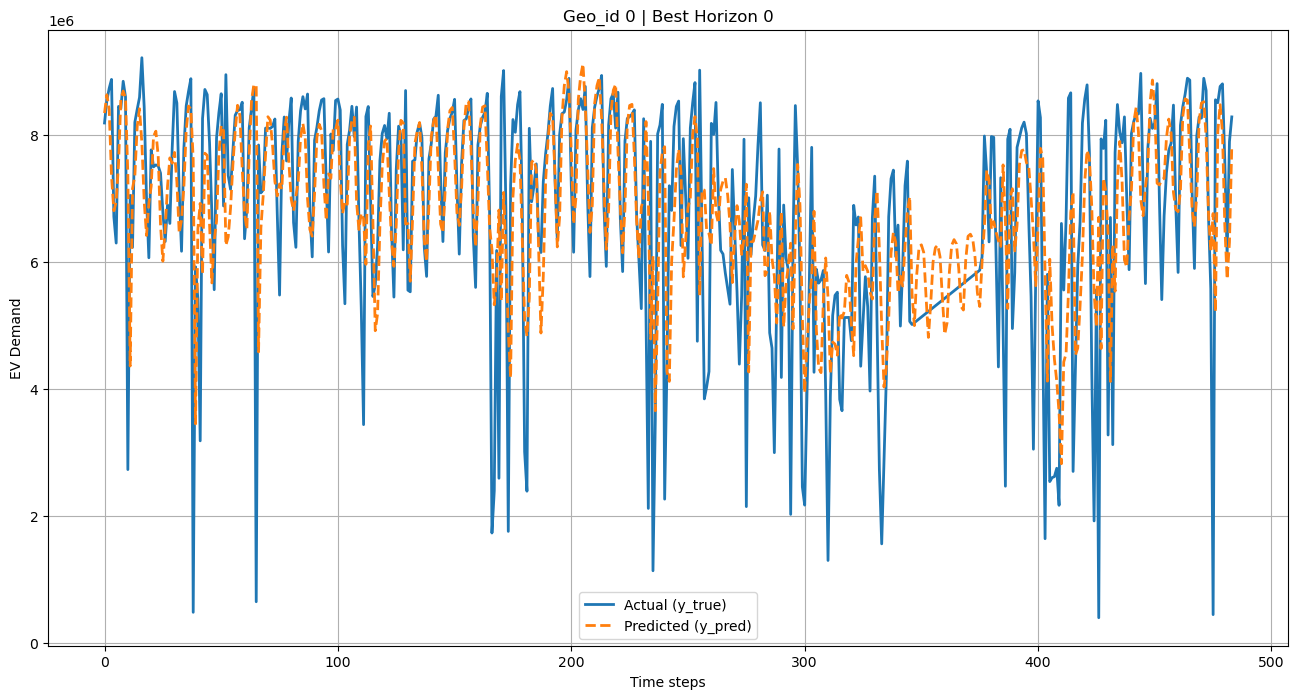

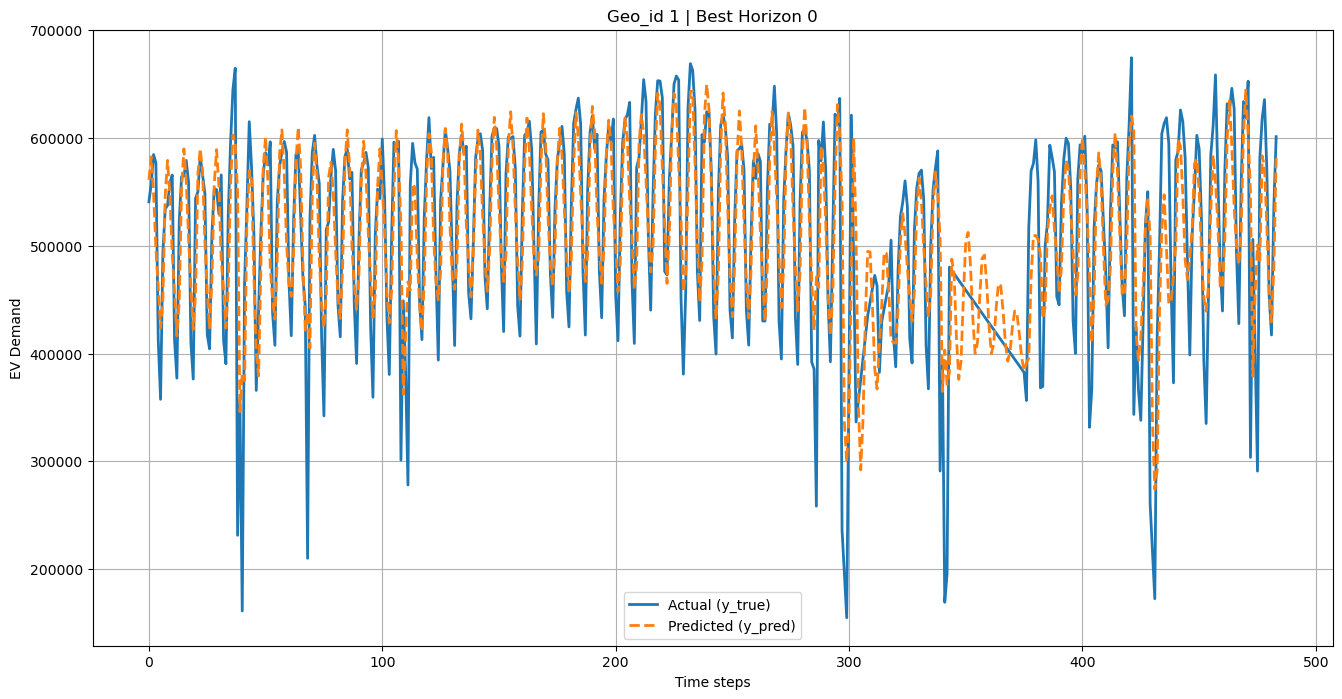

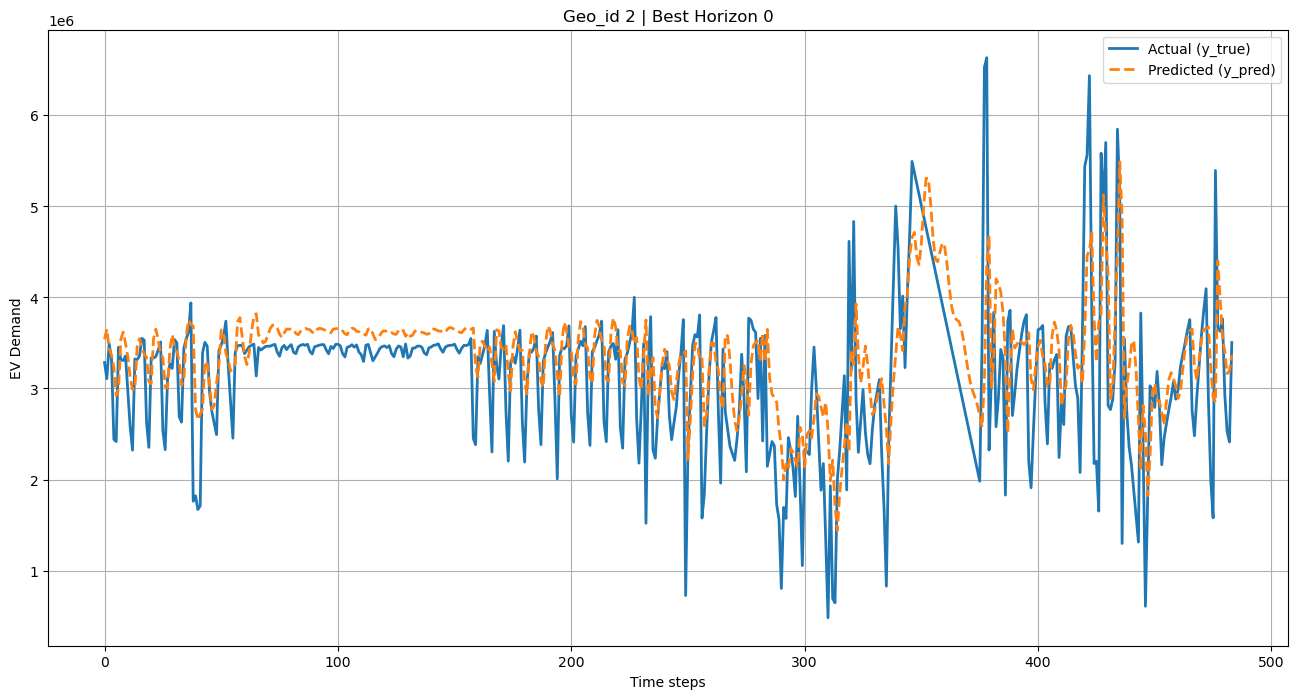

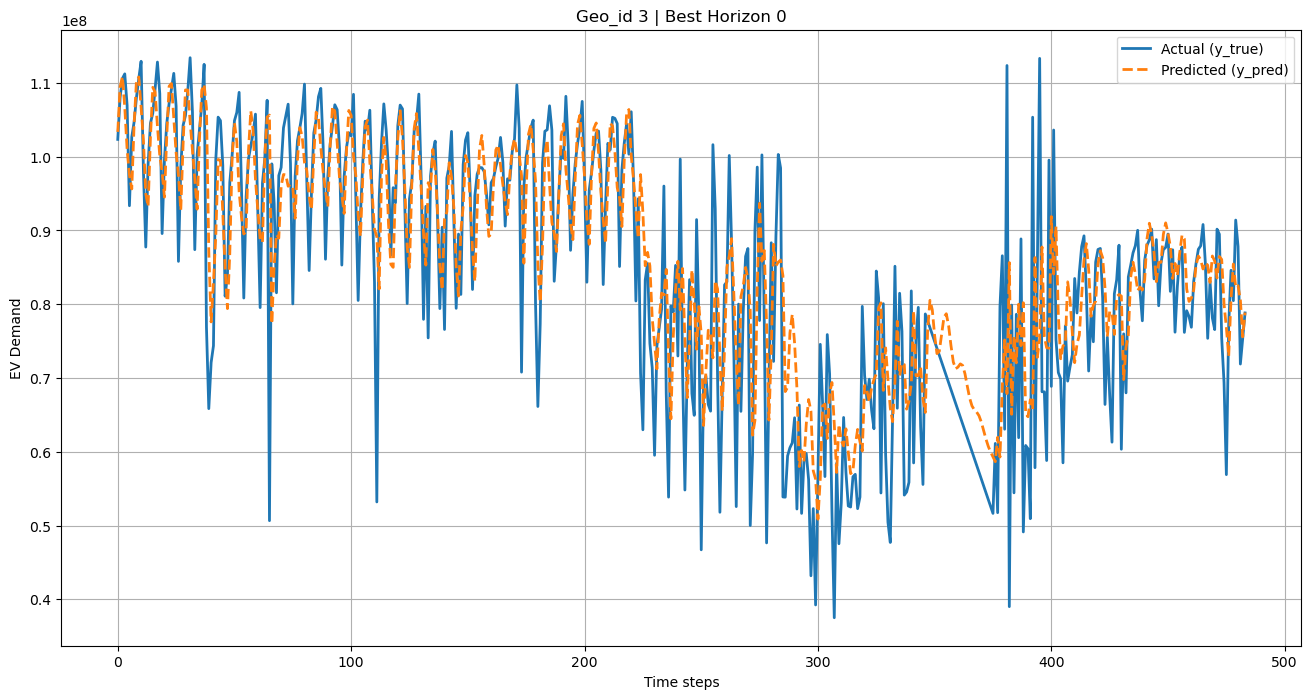

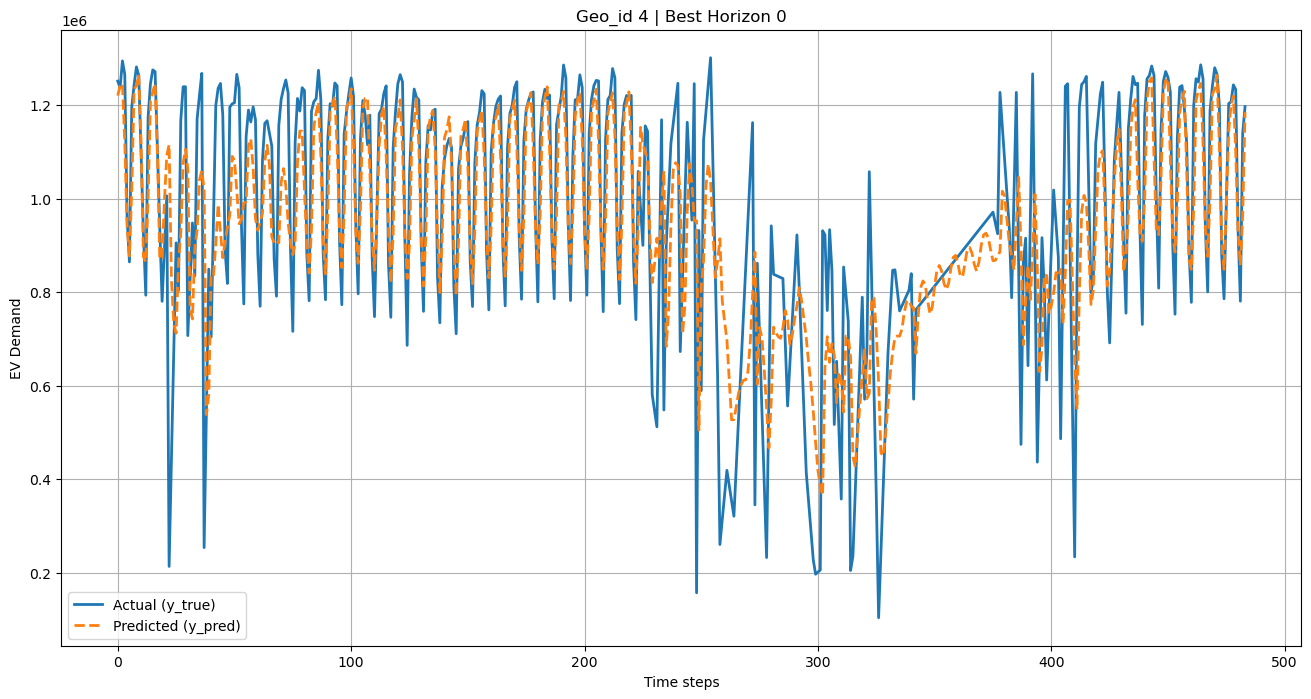

In [37]:
for geo_id, res in best_GRU_result.items():
    plt.figure(figsize=(16, 8))
    plt.plot(res["y_test"], label="Actual (y_true)", linewidth=2)
    plt.plot(res["y_pred"], label="Predicted (y_pred)", linewidth=2, linestyle="--")
    plt.title(f"Geo_id {geo_id} | Best Horizon {res['horizon']}")
    plt.xlabel("Time steps")
    plt.ylabel("EV Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

## Building a Seasonal Autoregressive Integrated Moving Average (SARIMA) model for prediction

In [38]:
# Function: Hybrid outlier fixing (DOW median + rolling median) with holiday guard
import numpy as np

def fix_outliers_hybrid(g, y='estimated_demand_kWh', win='7D', min_count_dow=5, drop_flag=True):
    g = g.copy()
    base = g[y]

    # Not modify event days (holidays)
    mask_event = (g.get('school_holiday', 0) == 1) | (g.get('public_holiday', 0) == 1)
    mask_out   = g.get('is_outlier', False).astype(bool) & (~mask_event)

    clean_col = f'{y}_clean'
    g[clean_col] = base

    if mask_out.any():
        # “Clean” reference for DOW median: exclude outliers and event days
        ref_mask = (~g.get('is_outlier', False).astype(bool)) & (~mask_event)

        dow = g.index.dayofweek  # 0=Mon ... 6=Sun
        # Median by each DOW
        ref_median_by_dow = g.loc[ref_mask, y].groupby(dow[ref_mask]).median()

        # Sample count by DOW to check reliability threshold
        ref_count_by_dow  = g.loc[ref_mask, y].groupby(dow[ref_mask]).size()

        # Map median & count back to each timestamp
        candidate_dow = dow.map(ref_median_by_dow)
        count_dow     = dow.map(ref_count_by_dow).fillna(0)
        ok_dow        = count_dow.values >= min_count_dow

        # Fallback: time-based rolling median
        med_roll = base.rolling(win, center=True, min_periods=1).median()

        # Replacement vector for outlier positions
        repl = np.where(ok_dow, candidate_dow.to_numpy(), med_roll.to_numpy())

        # 5) Assign back ONLY at outlier positions (don’t change event days)
        idx = mask_out.values
        g.loc[idx, clean_col] = repl[idx]

    if drop_flag and 'is_outlier' in g.columns:
        g = g.drop(columns=['is_outlier'])

    return g

# Apply by geo_cluster
geo_clean_ARIMA = (
    geo_data
    .groupby('geo_cluster', group_keys=False)
    .apply(fix_outliers_hybrid, y='estimated_demand_kWh', win='7D', min_count_dow=5, drop_flag=True)
)


In [39]:
geo_clean.head(5)

Date  estimated_demand_kWh  public_holiday  school_holiday   Avg_Temp  \
0 2020-01-01            6961596.71             0.0             1.0  22.212222   
1 2020-01-02            6097220.65             0.0             1.0  22.678611   
2 2020-01-03            6768273.57             0.0             1.0  24.792778   
3 2020-01-04            6564854.03             0.0             1.0  29.069444   
4 2020-01-05            7175393.52             0.0             1.0  22.412778   

   Avg_Humidity   Avg_Wind  is_weekend  geo_cluster  
0     70.291667  22.471667         0.0           -1  
1     69.972222  20.998333         0.0           -1  
2     72.819444  18.131667         0.0           -1  
3     56.232778  26.944444         1.0           -1  
4     66.529444  34.073889         1.0           -1

Create function for splitting data for SARIMA model

In [40]:
def split_data(df, start_year, end_year):
    train_df = df.loc[f"{start_year}":f"{end_year}"]
    test_df  = df.loc[f"{end_year+1}":]
    x_train = train_df.drop(columns=['estimated_demand_kWh'])
    y_train = train_df['estimated_demand_kWh']
    x_test = test_df.drop(columns=['estimated_demand_kWh'])
    y_test = test_df['estimated_demand_kWh']
    return x_train, y_train, x_test, y_test


Define the parameters for SARIMA Model

In [44]:
start_q = 2
d = 1
start_p = 1
start_P=0
max_P=2
max_Q=2
max_p=3
max_q=3
ic='aic'

### Implement the SARIMA model

Import auto_arima library

In [45]:
from pmdarima.arima import auto_arima

In [46]:
SARIMA_model ={}

for i in geo_number:
  df = geo_clean_ARIMA[geo_clean_ARIMA['geo_cluster'] == i]
  df = df.drop(columns=['geo_cluster'])

  #Split the X_train, y_train, x_test and y_test for model
  X_train, y_train, X_test, y_test = split_data(df, start, end)

  #Apply autoarima to find the best combination of order and seasonal order
  am = auto_arima(
        y=y_train,
        exogenous=X_train,
        seasonal=True, m = 12,
        start_p=start_p, start_q=start_q, max_p=max_p, max_q=max_q,
        start_P=start_P, max_P=max_P, max_Q=max_Q,
        d=d, D=None,
        stepwise=True, trace=False,
        error_action='ignore', suppress_warnings=True,
        information_criterion=ic
    )

  order, seasonal_order = am.order, am.seasonal_order

  #Set the SARIMA model
  arima_model  = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
  arima_result = arima_model.fit()

  #Predict the values
  predict_EV_demand = arima_result.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

  result_metric = return_metrics(y_test, predict_EV_demand)
  mae, mape, rmse = result_metric


  SARIMA_model[i] = {
      "geo_id" : i,
      "arima_result" : arima_result,
      "order" : order,
      "seasonal_order" : seasonal_order,
      "mape" :mape,
      "mae" : mae,
      "rmse" : rmse,
      "predict_EV_demand": predict_EV_demand,
      "y_test" : y_test,
  }




MAE: 1132322.61
MAPE: 24.13%
RMSE: 1302280.860368
MAE: 283508.56
MAPE: 58.99%
RMSE: 284055.558699
MAE: 0.00
MAPE: 0.00%
RMSE: 0.000000
MAE: 451241.66
MAPE: 0.79%
RMSE: 2741305.236838
MAE: 30405.09
MAPE: 5.04%
RMSE: 45492.824638


### Evaluate the SARIMA model

In [47]:
print('SARIMA Model')
for geo_id, res in SARIMA_model.items():
  print(f"Geo_id: {geo_id}")
  print(f"MAPE: {res['mape']:.2%}")
  print(f"MSE: {res['mae']:.2f}")
  print(f"RMSE: {res['rmse']:.2f}")
  print("------------------")

SARIMA Model
Geo_id: 0
MAPE: 24.13%
MSE: 1132322.61
RMSE: 1302280.86
------------------
Geo_id: 1
MAPE: 58.99%
MSE: 283508.56
RMSE: 284055.56
------------------
Geo_id: 2
MAPE: 0.00%
MSE: 0.00
RMSE: 0.00
------------------
Geo_id: 3
MAPE: 0.79%
MSE: 451241.66
RMSE: 2741305.24
------------------
Geo_id: 4
MAPE: 5.04%
MSE: 30405.09
RMSE: 45492.82
------------------


Plot predicted and actual values

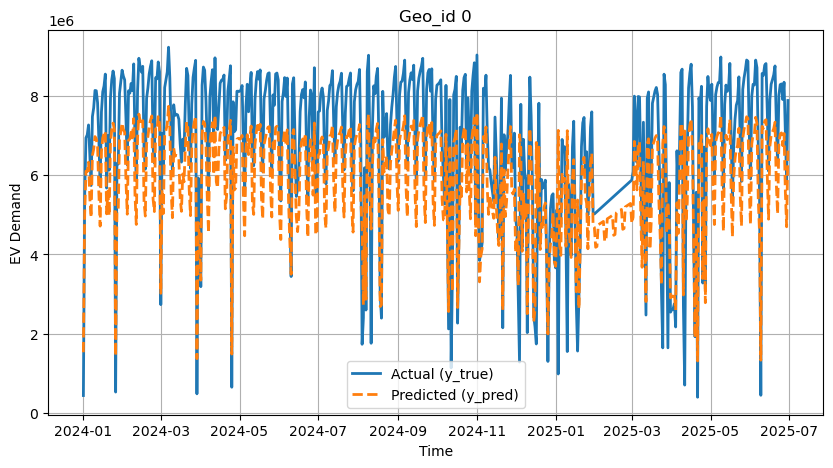

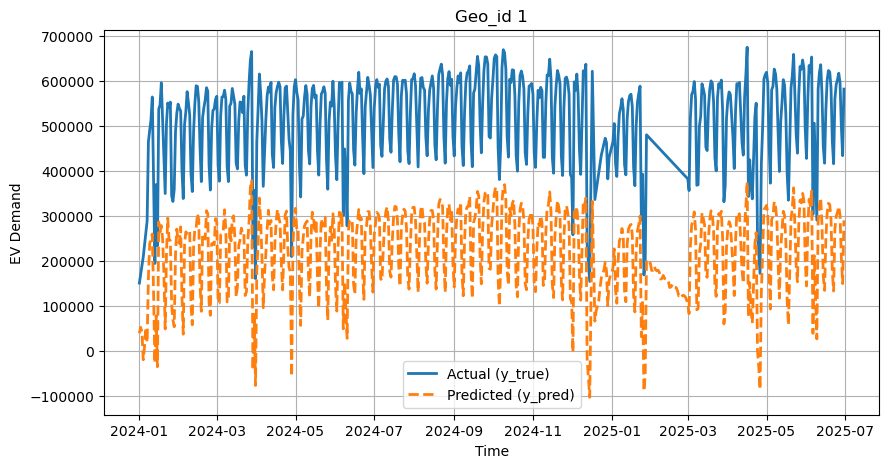

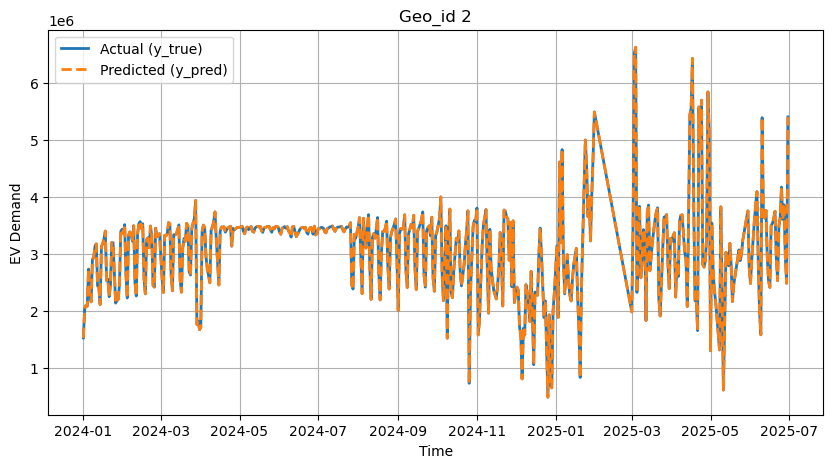

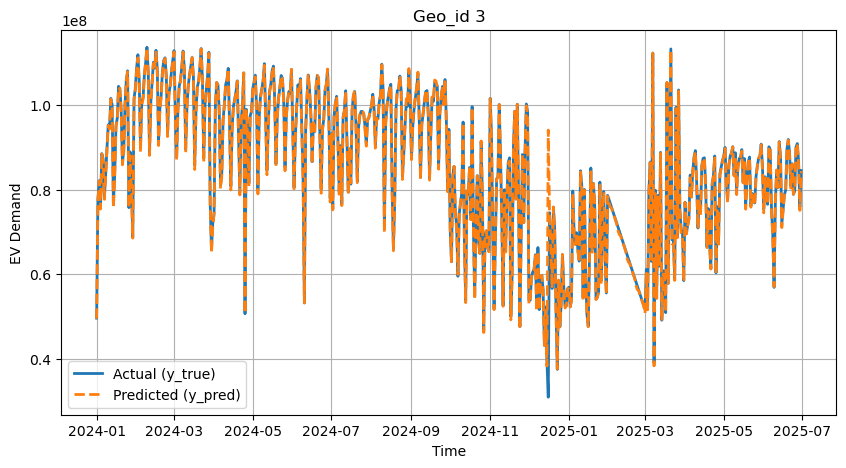

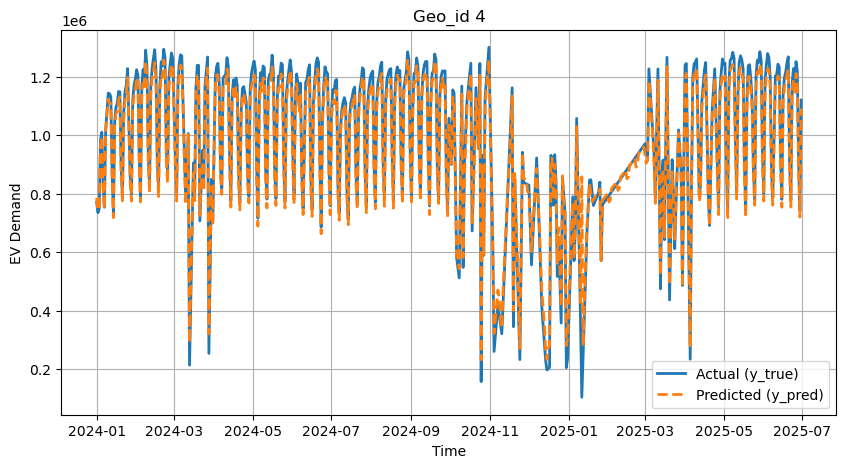

In [48]:
for geo_id, res in SARIMA_model.items():
    plt.figure(figsize=(10, 5))
    plt.plot(res["y_test"], label="Actual (y_true)", linewidth=2)
    plt.plot(res["predict_EV_demand"], label="Predicted (y_pred)", linewidth=2, linestyle="--")
    plt.title(f"Geo_id {geo_id}")
    plt.xlabel("Time")
    plt.ylabel("EV Demand")
    plt.legend()
    plt.grid(True)
    plt.show()


## Bulding the Prophet model for EV Charging Demand Prediction

Create a function to split for Prophet model

In [49]:
start = 2020
end   = 2023

def prophet_split_data(df, start, end, date_col='Date'):
    #Ensure the Date column in right format
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Create a mask for spliting train and test
    mask_train = df[date_col].dt.year.between(start, end)
    mask_test  = df[date_col].dt.year >= (end + 1)

    train_df = df.loc[mask_train].reset_index(drop=True)
    test_df  = df.loc[mask_test].reset_index(drop=True)
    return train_df, test_df


### Implement the Prophet Model

In [50]:
exog_cols

['public_holiday',
 'school_holiday',
 'Avg_Temp',
 'Avg_Humidity',
 'Avg_Wind',
 'is_weekend']

In [51]:
from scipy.stats import uniform

In [83]:
from prophet import Prophet
import itertools
import matplotlib.pyplot as plt

# Hyperparameter grid (you can expand these ranges)
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 5.0, 10.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all parameter combinations
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

Prophet_model = {}

for i in geo_number:
    # previous developer had the following line as "df = geo_clean[geo_clean['geo_cluster'] == i].reset_index().rename(columns={'index': 'Date'})"
    # - no idea why, vast majority of this code appears to be AI generated anyway
    df = geo_clean[geo_clean['geo_cluster'] == i].reset_index(drop=True)
    df.drop(columns=['geo_cluster'], inplace=True)

    # Split into train/test
    train_df, test_df = prophet_split_data(df, start, end)
    train_df = train_df.rename(columns={'Date':'ds', 'estimated_demand_kWh':'y'})
    test_df  = test_df.rename(columns={'Date':'ds', 'estimated_demand_kWh':'y'})

    best_score, best_params, best_model, best_forecast, best_metrics = float("inf"), None, None, None, None

    # Grid search
    for params in all_params:
        model = Prophet(**params)
        for col in exog_cols:
            model.add_regressor(col)

        cols_fit = ['ds', 'y'] + exog_cols
        model.fit(train_df[cols_fit])

        forecast_test = model.predict(test_df[['ds'] + exog_cols])
        forecast_test = forecast_test[['ds', 'yhat']]

        mae, mape, rmse = return_metrics(test_df['y'], forecast_test['yhat'])

        # Pick the model with lowest MAPE
        if mape < best_score:
            best_score = mape
            best_params = params
            best_model = model
            best_forecast = forecast_test.copy()
            best_metrics = (mae, mape, rmse)

    mae, mape, rmse = best_metrics
    Prophet_model[i] = {
        "geo_id" : i,
        "prophet_model" : best_model,
        "best_params" : best_params,
        "mape" : mape,
        "mae" : mae,
        "rmse" : rmse,
        "y_test" : test_df[['ds','y']],          # actual values
        "y_pred" : best_forecast[['ds','yhat']], # predictions
    }

17:26:52 - cmdstanpy - INFO - Chain [1] start processing
17:26:52 - cmdstanpy - INFO - Chain [1] done processing
17:26:52 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1410769.68
MAPE: 47.05%
RMSE: 2117679.094927


17:26:53 - cmdstanpy - INFO - Chain [1] done processing
17:26:53 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1396621.91
MAPE: 47.04%
RMSE: 2124914.570487


17:26:53 - cmdstanpy - INFO - Chain [1] done processing
17:26:53 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1395211.66
MAPE: 46.62%
RMSE: 2098608.201769


17:26:53 - cmdstanpy - INFO - Chain [1] done processing
17:26:54 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1399351.00
MAPE: 47.10%
RMSE: 2127873.841009


17:26:54 - cmdstanpy - INFO - Chain [1] done processing
17:26:54 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1390992.69
MAPE: 46.50%
RMSE: 2093146.231970


17:26:54 - cmdstanpy - INFO - Chain [1] done processing
17:26:55 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1396655.23
MAPE: 47.04%
RMSE: 2124811.731314


17:26:55 - cmdstanpy - INFO - Chain [1] done processing
17:26:55 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1395158.46
MAPE: 46.62%
RMSE: 2098506.684330


17:26:55 - cmdstanpy - INFO - Chain [1] done processing
17:26:56 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1399806.41
MAPE: 47.11%
RMSE: 2128460.493510


17:26:56 - cmdstanpy - INFO - Chain [1] done processing
17:26:56 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1335555.57
MAPE: 44.64%
RMSE: 2004584.977096


17:26:56 - cmdstanpy - INFO - Chain [1] done processing
17:26:57 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1330790.23
MAPE: 43.30%
RMSE: 1953200.579663


17:26:57 - cmdstanpy - INFO - Chain [1] done processing
17:26:57 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1341924.09
MAPE: 44.86%
RMSE: 2015145.969141


17:26:57 - cmdstanpy - INFO - Chain [1] done processing
17:26:58 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1330988.15
MAPE: 43.32%
RMSE: 1954416.359231


17:26:58 - cmdstanpy - INFO - Chain [1] done processing
17:26:58 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1326822.20
MAPE: 44.11%
RMSE: 1978515.781401


17:26:58 - cmdstanpy - INFO - Chain [1] done processing
17:26:59 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1330704.48
MAPE: 43.30%
RMSE: 1953306.883960


17:26:59 - cmdstanpy - INFO - Chain [1] done processing
17:26:59 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1335392.27
MAPE: 44.60%
RMSE: 2001484.452928


17:26:59 - cmdstanpy - INFO - Chain [1] done processing
17:27:00 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1330595.99
MAPE: 43.29%
RMSE: 1953033.916513


17:27:00 - cmdstanpy - INFO - Chain [1] done processing
17:27:00 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3587257.11
MAPE: 90.22%
RMSE: 4241562.923485


17:27:01 - cmdstanpy - INFO - Chain [1] done processing
17:27:01 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3332945.16
MAPE: 84.42%
RMSE: 4057396.952851


17:27:02 - cmdstanpy - INFO - Chain [1] done processing
17:27:02 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3567665.93
MAPE: 89.85%
RMSE: 4222828.260584


17:27:03 - cmdstanpy - INFO - Chain [1] done processing
17:27:04 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2126161.61
MAPE: 61.63%
RMSE: 2838493.540337


17:27:04 - cmdstanpy - INFO - Chain [1] done processing
17:27:04 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3568596.62
MAPE: 89.87%
RMSE: 4224099.421701


17:27:06 - cmdstanpy - INFO - Chain [1] done processing
17:27:06 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2062422.39
MAPE: 60.41%
RMSE: 2778245.802284


17:27:07 - cmdstanpy - INFO - Chain [1] done processing
17:27:07 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3555699.32
MAPE: 89.63%
RMSE: 4211839.140451


17:27:09 - cmdstanpy - INFO - Chain [1] done processing
17:27:10 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1776091.00
MAPE: 54.94%
RMSE: 2511452.179548


17:27:11 - cmdstanpy - INFO - Chain [1] done processing
17:27:11 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2275082.65
MAPE: 65.26%
RMSE: 2961789.045286


17:27:12 - cmdstanpy - INFO - Chain [1] done processing
17:27:13 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1395027.20
MAPE: 47.12%
RMSE: 2129748.769962


17:27:13 - cmdstanpy - INFO - Chain [1] done processing
17:27:14 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2262372.41
MAPE: 65.02%
RMSE: 2950377.994553


17:27:16 - cmdstanpy - INFO - Chain [1] done processing
17:27:16 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1335335.75
MAPE: 45.76%
RMSE: 2067487.123018


17:27:17 - cmdstanpy - INFO - Chain [1] done processing
17:27:17 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2272017.09
MAPE: 65.19%
RMSE: 2957670.753577


17:27:19 - cmdstanpy - INFO - Chain [1] done processing
17:27:20 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1259540.55
MAPE: 43.98%
RMSE: 1980523.170803


17:27:20 - cmdstanpy - INFO - Chain [1] done processing
17:27:21 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1923262.65
MAPE: 58.42%
RMSE: 2627648.661895


17:27:23 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1321646.23
MAPE: 45.51%
RMSE: 2056373.168583


17:27:24 - cmdstanpy - INFO - Chain [1] start processing
17:27:24 - cmdstanpy - INFO - Chain [1] done processing
17:27:24 - cmdstanpy - INFO - Chain [1] start processing


MAE: 122040.86
MAPE: 25.09%
RMSE: 137893.736697


17:27:24 - cmdstanpy - INFO - Chain [1] done processing
17:27:25 - cmdstanpy - INFO - Chain [1] start processing


MAE: 170024.72
MAPE: 33.96%
RMSE: 181023.590180


17:27:25 - cmdstanpy - INFO - Chain [1] done processing
17:27:25 - cmdstanpy - INFO - Chain [1] start processing


MAE: 120095.74
MAPE: 24.76%
RMSE: 136197.442970


17:27:25 - cmdstanpy - INFO - Chain [1] done processing
17:27:26 - cmdstanpy - INFO - Chain [1] start processing


MAE: 104503.11
MAPE: 21.82%
RMSE: 121843.794055


17:27:26 - cmdstanpy - INFO - Chain [1] done processing
17:27:26 - cmdstanpy - INFO - Chain [1] start processing


MAE: 121254.28
MAPE: 24.95%
RMSE: 137233.227687


17:27:26 - cmdstanpy - INFO - Chain [1] done processing
17:27:27 - cmdstanpy - INFO - Chain [1] start processing


MAE: 125640.35
MAPE: 25.56%
RMSE: 139522.790878


17:27:27 - cmdstanpy - INFO - Chain [1] done processing
17:27:27 - cmdstanpy - INFO - Chain [1] start processing


MAE: 120325.46
MAPE: 24.79%
RMSE: 136387.184125


17:27:27 - cmdstanpy - INFO - Chain [1] done processing
17:27:28 - cmdstanpy - INFO - Chain [1] start processing


MAE: 117631.61
MAPE: 24.15%
RMSE: 132564.420851


17:27:28 - cmdstanpy - INFO - Chain [1] done processing
17:27:28 - cmdstanpy - INFO - Chain [1] start processing


MAE: 84478.73
MAPE: 18.57%
RMSE: 104045.919014


17:27:28 - cmdstanpy - INFO - Chain [1] done processing
17:27:29 - cmdstanpy - INFO - Chain [1] start processing


MAE: 80093.84
MAPE: 17.88%
RMSE: 101598.148276


17:27:29 - cmdstanpy - INFO - Chain [1] done processing
17:27:29 - cmdstanpy - INFO - Chain [1] start processing


MAE: 87093.40
MAPE: 18.98%
RMSE: 105846.356604


17:27:29 - cmdstanpy - INFO - Chain [1] done processing
17:27:30 - cmdstanpy - INFO - Chain [1] start processing


MAE: 73925.76
MAPE: 16.97%
RMSE: 97843.093366


17:27:30 - cmdstanpy - INFO - Chain [1] done processing
17:27:30 - cmdstanpy - INFO - Chain [1] start processing


MAE: 89799.42
MAPE: 19.42%
RMSE: 107930.103458


17:27:30 - cmdstanpy - INFO - Chain [1] done processing
17:27:31 - cmdstanpy - INFO - Chain [1] start processing


MAE: 75118.11
MAPE: 17.14%
RMSE: 98566.172634


17:27:31 - cmdstanpy - INFO - Chain [1] done processing
17:27:31 - cmdstanpy - INFO - Chain [1] start processing


MAE: 89839.81
MAPE: 19.42%
RMSE: 107954.383121


17:27:31 - cmdstanpy - INFO - Chain [1] done processing
17:27:32 - cmdstanpy - INFO - Chain [1] start processing


MAE: 73825.34
MAPE: 16.95%
RMSE: 97715.754013


17:27:32 - cmdstanpy - INFO - Chain [1] done processing
17:27:32 - cmdstanpy - INFO - Chain [1] start processing


MAE: 205316.36
MAPE: 40.57%
RMSE: 224039.121474


17:27:33 - cmdstanpy - INFO - Chain [1] done processing
17:27:34 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1023314.50
MAPE: 204.14%
RMSE: 1092980.265685


17:27:34 - cmdstanpy - INFO - Chain [1] done processing
17:27:34 - cmdstanpy - INFO - Chain [1] start processing


MAE: 207475.87
MAPE: 40.99%
RMSE: 226270.613425


17:27:36 - cmdstanpy - INFO - Chain [1] done processing
17:27:36 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1091331.68
MAPE: 217.73%
RMSE: 1169363.063646


17:27:37 - cmdstanpy - INFO - Chain [1] done processing
17:27:37 - cmdstanpy - INFO - Chain [1] start processing


MAE: 205682.32
MAPE: 40.64%
RMSE: 224375.560194


17:27:40 - cmdstanpy - INFO - Chain [1] done processing
17:27:40 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1107424.32
MAPE: 220.91%
RMSE: 1187859.668393


17:27:40 - cmdstanpy - INFO - Chain [1] done processing
17:27:41 - cmdstanpy - INFO - Chain [1] start processing


MAE: 174475.11
MAPE: 34.64%
RMSE: 192587.843100


17:27:42 - cmdstanpy - INFO - Chain [1] done processing
17:27:43 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1123800.10
MAPE: 224.18%
RMSE: 1206518.833881


17:27:43 - cmdstanpy - INFO - Chain [1] done processing
17:27:44 - cmdstanpy - INFO - Chain [1] start processing


MAE: 890489.68
MAPE: 183.56%
RMSE: 942548.300023


17:27:45 - cmdstanpy - INFO - Chain [1] done processing
17:27:45 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1160727.51
MAPE: 231.45%
RMSE: 1249729.471697


17:27:46 - cmdstanpy - INFO - Chain [1] done processing
17:27:47 - cmdstanpy - INFO - Chain [1] start processing


MAE: 885558.47
MAPE: 182.53%
RMSE: 937234.512408


17:27:49 - cmdstanpy - INFO - Chain [1] done processing
17:27:49 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1171311.00
MAPE: 233.44%
RMSE: 1263138.958897


17:27:50 - cmdstanpy - INFO - Chain [1] done processing
17:27:50 - cmdstanpy - INFO - Chain [1] start processing


MAE: 883041.11
MAPE: 182.00%
RMSE: 934576.622999


17:27:52 - cmdstanpy - INFO - Chain [1] done processing
17:27:52 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1177479.20
MAPE: 234.71%
RMSE: 1270018.927614


17:27:53 - cmdstanpy - INFO - Chain [1] done processing
17:27:53 - cmdstanpy - INFO - Chain [1] start processing


MAE: 872706.54
MAPE: 179.82%
RMSE: 923564.193718


17:27:56 - cmdstanpy - INFO - Chain [1] done processing
17:27:56 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1174180.29
MAPE: 234.04%
RMSE: 1266179.126370


17:27:56 - cmdstanpy - INFO - Chain [1] done processing
17:27:57 - cmdstanpy - INFO - Chain [1] start processing


MAE: 810378.39
MAPE: 31.47%
RMSE: 1031893.780490


17:27:57 - cmdstanpy - INFO - Chain [1] done processing
17:27:57 - cmdstanpy - INFO - Chain [1] start processing


MAE: 669114.04
MAPE: 26.96%
RMSE: 896642.600991


17:27:57 - cmdstanpy - INFO - Chain [1] done processing
17:27:58 - cmdstanpy - INFO - Chain [1] start processing


MAE: 816001.33
MAPE: 31.73%
RMSE: 1037317.783764


17:27:58 - cmdstanpy - INFO - Chain [1] done processing
17:27:58 - cmdstanpy - INFO - Chain [1] start processing


MAE: 665168.84
MAPE: 26.69%
RMSE: 892573.781374


17:27:59 - cmdstanpy - INFO - Chain [1] done processing
17:27:59 - cmdstanpy - INFO - Chain [1] start processing


MAE: 815214.49
MAPE: 31.70%
RMSE: 1036554.619511


17:27:59 - cmdstanpy - INFO - Chain [1] done processing
17:27:59 - cmdstanpy - INFO - Chain [1] start processing


MAE: 665025.22
MAPE: 26.69%
RMSE: 892490.092880


17:27:59 - cmdstanpy - INFO - Chain [1] done processing
17:28:00 - cmdstanpy - INFO - Chain [1] start processing


MAE: 814907.14
MAPE: 31.68%
RMSE: 1036257.405934


17:28:00 - cmdstanpy - INFO - Chain [1] done processing
17:28:00 - cmdstanpy - INFO - Chain [1] start processing


MAE: 665959.36
MAPE: 26.71%
RMSE: 893302.983791


17:28:00 - cmdstanpy - INFO - Chain [1] done processing
17:28:01 - cmdstanpy - INFO - Chain [1] start processing


MAE: 796641.24
MAPE: 29.24%
RMSE: 1037799.111109


17:28:01 - cmdstanpy - INFO - Chain [1] done processing
17:28:01 - cmdstanpy - INFO - Chain [1] start processing


MAE: 703022.99
MAPE: 25.57%
RMSE: 944310.055469


17:28:01 - cmdstanpy - INFO - Chain [1] done processing
17:28:02 - cmdstanpy - INFO - Chain [1] start processing


MAE: 795085.35
MAPE: 29.20%
RMSE: 1036307.715843


17:28:02 - cmdstanpy - INFO - Chain [1] done processing
17:28:02 - cmdstanpy - INFO - Chain [1] start processing


MAE: 702545.68
MAPE: 25.57%
RMSE: 943725.985044


17:28:03 - cmdstanpy - INFO - Chain [1] done processing
17:28:03 - cmdstanpy - INFO - Chain [1] start processing


MAE: 793744.28
MAPE: 29.19%
RMSE: 1033666.168448


17:28:03 - cmdstanpy - INFO - Chain [1] done processing
17:28:03 - cmdstanpy - INFO - Chain [1] start processing


MAE: 700389.02
MAPE: 25.54%
RMSE: 941149.968836


17:28:04 - cmdstanpy - INFO - Chain [1] done processing
17:28:04 - cmdstanpy - INFO - Chain [1] start processing


MAE: 792601.41
MAPE: 29.15%
RMSE: 1032533.802389


17:28:04 - cmdstanpy - INFO - Chain [1] done processing
17:28:04 - cmdstanpy - INFO - Chain [1] start processing


MAE: 699336.57
MAPE: 25.53%
RMSE: 939968.076495


17:28:05 - cmdstanpy - INFO - Chain [1] done processing
17:28:05 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1056961.67
MAPE: 34.73%
RMSE: 1357656.451414


17:28:05 - cmdstanpy - INFO - Chain [1] done processing
17:28:06 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1213762.94
MAPE: 37.74%
RMSE: 1492281.045078


17:28:06 - cmdstanpy - INFO - Chain [1] done processing
17:28:06 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1028751.96
MAPE: 34.01%
RMSE: 1324971.956432


17:28:07 - cmdstanpy - INFO - Chain [1] done processing
17:28:08 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1356511.94
MAPE: 41.92%
RMSE: 1635868.477345


17:28:08 - cmdstanpy - INFO - Chain [1] done processing
17:28:08 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1053694.10
MAPE: 34.65%
RMSE: 1353670.805338


17:28:08 - cmdstanpy - INFO - Chain [1] done processing
17:28:09 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1197169.70
MAPE: 37.27%
RMSE: 1474861.059358


17:28:09 - cmdstanpy - INFO - Chain [1] done processing
17:28:09 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1044260.05
MAPE: 34.41%
RMSE: 1342791.849784


17:28:10 - cmdstanpy - INFO - Chain [1] done processing
17:28:10 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1194150.18
MAPE: 37.18%
RMSE: 1471679.621057


17:28:11 - cmdstanpy - INFO - Chain [1] done processing
17:28:11 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3310589.62
MAPE: 109.47%
RMSE: 3716776.104299


17:28:12 - cmdstanpy - INFO - Chain [1] done processing
17:28:13 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3067155.52
MAPE: 99.47%
RMSE: 3384902.786899


17:28:13 - cmdstanpy - INFO - Chain [1] done processing
17:28:14 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3565857.11
MAPE: 118.34%
RMSE: 3984834.541216


17:28:16 - cmdstanpy - INFO - Chain [1] done processing
17:28:16 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3122402.76
MAPE: 101.40%
RMSE: 3442282.617550


17:28:17 - cmdstanpy - INFO - Chain [1] done processing
17:28:17 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3713711.90
MAPE: 123.46%
RMSE: 4140996.733012


17:28:18 - cmdstanpy - INFO - Chain [1] done processing
17:28:19 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3180847.38
MAPE: 103.48%
RMSE: 3504669.576423


17:28:19 - cmdstanpy - INFO - Chain [1] done processing
17:28:20 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3285496.07
MAPE: 108.60%
RMSE: 3690070.680890


17:28:22 - cmdstanpy - INFO - Chain [1] done processing


MAE: 3069541.82
MAPE: 99.52%
RMSE: 3390919.788432


17:28:22 - cmdstanpy - INFO - Chain [1] start processing
17:28:22 - cmdstanpy - INFO - Chain [1] done processing
17:28:23 - cmdstanpy - INFO - Chain [1] start processing


MAE: 20371206.46
MAPE: 29.47%
RMSE: 26996428.369146


17:28:23 - cmdstanpy - INFO - Chain [1] done processing
17:28:23 - cmdstanpy - INFO - Chain [1] start processing


MAE: 19423876.95
MAPE: 28.05%
RMSE: 26008992.359824


17:28:23 - cmdstanpy - INFO - Chain [1] done processing
17:28:24 - cmdstanpy - INFO - Chain [1] start processing


MAE: 20319129.91
MAPE: 29.40%
RMSE: 26947691.859743


17:28:24 - cmdstanpy - INFO - Chain [1] done processing
17:28:24 - cmdstanpy - INFO - Chain [1] start processing


MAE: 20936375.39
MAPE: 30.11%
RMSE: 27682036.543339


17:28:24 - cmdstanpy - INFO - Chain [1] done processing
17:28:25 - cmdstanpy - INFO - Chain [1] start processing


MAE: 20419591.94
MAPE: 29.53%
RMSE: 27049950.787967


17:28:25 - cmdstanpy - INFO - Chain [1] done processing
17:28:25 - cmdstanpy - INFO - Chain [1] start processing


MAE: 20324610.66
MAPE: 29.38%
RMSE: 27148388.710672


17:28:26 - cmdstanpy - INFO - Chain [1] done processing
17:28:26 - cmdstanpy - INFO - Chain [1] start processing


MAE: 20441763.99
MAPE: 29.56%
RMSE: 27074718.259711


17:28:26 - cmdstanpy - INFO - Chain [1] done processing
17:28:27 - cmdstanpy - INFO - Chain [1] start processing


MAE: 20316912.79
MAPE: 29.37%
RMSE: 27140382.566076


17:28:27 - cmdstanpy - INFO - Chain [1] done processing
17:28:27 - cmdstanpy - INFO - Chain [1] start processing


MAE: 18220669.06
MAPE: 26.41%
RMSE: 24560806.324989


17:28:27 - cmdstanpy - INFO - Chain [1] done processing
17:28:28 - cmdstanpy - INFO - Chain [1] start processing


MAE: 17495718.02
MAPE: 25.27%
RMSE: 23623445.905725


17:28:28 - cmdstanpy - INFO - Chain [1] done processing
17:28:28 - cmdstanpy - INFO - Chain [1] start processing


MAE: 18139884.71
MAPE: 26.30%
RMSE: 24470791.719404


17:28:28 - cmdstanpy - INFO - Chain [1] done processing
17:28:29 - cmdstanpy - INFO - Chain [1] start processing


MAE: 17744251.28
MAPE: 25.60%
RMSE: 23895920.700061


17:28:29 - cmdstanpy - INFO - Chain [1] done processing
17:28:29 - cmdstanpy - INFO - Chain [1] start processing


MAE: 17952596.06
MAPE: 26.04%
RMSE: 24254408.476675


17:28:29 - cmdstanpy - INFO - Chain [1] done processing
17:28:30 - cmdstanpy - INFO - Chain [1] start processing


MAE: 17819994.67
MAPE: 25.75%
RMSE: 24052593.075529


17:28:30 - cmdstanpy - INFO - Chain [1] done processing
17:28:30 - cmdstanpy - INFO - Chain [1] start processing


MAE: 18216913.16
MAPE: 26.43%
RMSE: 24578086.059639


17:28:30 - cmdstanpy - INFO - Chain [1] done processing
17:28:31 - cmdstanpy - INFO - Chain [1] start processing


MAE: 17745337.61
MAPE: 25.63%
RMSE: 23937324.938084


17:28:31 - cmdstanpy - INFO - Chain [1] done processing
17:28:31 - cmdstanpy - INFO - Chain [1] start processing


MAE: 30858785.20
MAPE: 43.31%
RMSE: 38075154.287690


17:28:32 - cmdstanpy - INFO - Chain [1] done processing
17:28:32 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13077681.98
MAPE: 18.69%
RMSE: 17640440.990042


17:28:33 - cmdstanpy - INFO - Chain [1] done processing
17:28:33 - cmdstanpy - INFO - Chain [1] start processing


MAE: 30645245.57
MAPE: 43.02%
RMSE: 37853794.275084


17:28:34 - cmdstanpy - INFO - Chain [1] done processing
17:28:35 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13585085.64
MAPE: 19.62%
RMSE: 18579860.444526


17:28:35 - cmdstanpy - INFO - Chain [1] done processing
17:28:35 - cmdstanpy - INFO - Chain [1] start processing


MAE: 30930266.76
MAPE: 43.40%
RMSE: 38148208.859983


17:28:38 - cmdstanpy - INFO - Chain [1] done processing
17:28:38 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14177643.76
MAPE: 20.62%
RMSE: 19558836.475461


17:28:38 - cmdstanpy - INFO - Chain [1] done processing
17:28:39 - cmdstanpy - INFO - Chain [1] start processing


MAE: 30360531.20
MAPE: 42.66%
RMSE: 37570686.724201


17:28:41 - cmdstanpy - INFO - Chain [1] done processing
17:28:41 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14441346.42
MAPE: 21.00%
RMSE: 19892930.707911


17:28:42 - cmdstanpy - INFO - Chain [1] done processing
17:28:43 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13813755.19
MAPE: 19.97%
RMSE: 18935745.214752


17:28:44 - cmdstanpy - INFO - Chain [1] done processing
17:28:44 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14413804.51
MAPE: 20.98%
RMSE: 19836938.169971


17:28:45 - cmdstanpy - INFO - Chain [1] done processing
17:28:46 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13822875.15
MAPE: 19.98%
RMSE: 18939234.125129


17:28:47 - cmdstanpy - INFO - Chain [1] done processing
17:28:48 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15757081.84
MAPE: 22.87%
RMSE: 21454994.492074


17:28:49 - cmdstanpy - INFO - Chain [1] done processing
17:28:49 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13652381.73
MAPE: 19.69%
RMSE: 18661761.470494


17:28:51 - cmdstanpy - INFO - Chain [1] done processing
17:28:51 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15366165.81
MAPE: 22.31%
RMSE: 20955122.674816


17:28:52 - cmdstanpy - INFO - Chain [1] done processing
17:28:52 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13430987.93
MAPE: 19.26%
RMSE: 18208640.095211


17:28:55 - cmdstanpy - INFO - Chain [1] done processing
17:28:55 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15594048.44
MAPE: 22.65%
RMSE: 21256117.601103


17:28:55 - cmdstanpy - INFO - Chain [1] done processing
17:28:56 - cmdstanpy - INFO - Chain [1] start processing


MAE: 208337.87
MAPE: 33.74%
RMSE: 279906.864696


17:28:56 - cmdstanpy - INFO - Chain [1] done processing
17:28:56 - cmdstanpy - INFO - Chain [1] start processing


MAE: 211850.61
MAPE: 32.73%
RMSE: 270168.422098


17:28:56 - cmdstanpy - INFO - Chain [1] done processing
17:28:57 - cmdstanpy - INFO - Chain [1] start processing


MAE: 208340.68
MAPE: 33.74%
RMSE: 279914.084105


17:28:57 - cmdstanpy - INFO - Chain [1] done processing
17:28:57 - cmdstanpy - INFO - Chain [1] start processing


MAE: 211291.72
MAPE: 32.61%
RMSE: 268669.189350


17:28:58 - cmdstanpy - INFO - Chain [1] done processing
17:28:58 - cmdstanpy - INFO - Chain [1] start processing


MAE: 208340.72
MAPE: 33.74%
RMSE: 279914.245963


17:28:58 - cmdstanpy - INFO - Chain [1] done processing
17:28:59 - cmdstanpy - INFO - Chain [1] start processing


MAE: 209021.49
MAPE: 32.55%
RMSE: 267608.978011


17:28:59 - cmdstanpy - INFO - Chain [1] done processing
17:28:59 - cmdstanpy - INFO - Chain [1] start processing


MAE: 208340.67
MAPE: 33.74%
RMSE: 279914.077690


17:28:59 - cmdstanpy - INFO - Chain [1] done processing
17:29:00 - cmdstanpy - INFO - Chain [1] start processing


MAE: 205590.64
MAPE: 32.50%
RMSE: 265754.442458


17:29:00 - cmdstanpy - INFO - Chain [1] done processing
17:29:00 - cmdstanpy - INFO - Chain [1] start processing


MAE: 201776.46
MAPE: 34.93%
RMSE: 289587.609118


17:29:01 - cmdstanpy - INFO - Chain [1] done processing
17:29:01 - cmdstanpy - INFO - Chain [1] start processing


MAE: 203449.23
MAPE: 34.30%
RMSE: 287776.311824


17:29:01 - cmdstanpy - INFO - Chain [1] done processing
17:29:01 - cmdstanpy - INFO - Chain [1] start processing


MAE: 203224.99
MAPE: 35.30%
RMSE: 292405.172149


17:29:01 - cmdstanpy - INFO - Chain [1] done processing
17:29:02 - cmdstanpy - INFO - Chain [1] start processing


MAE: 203538.69
MAPE: 34.27%
RMSE: 287468.368181


17:29:02 - cmdstanpy - INFO - Chain [1] done processing
17:29:02 - cmdstanpy - INFO - Chain [1] start processing


MAE: 202415.35
MAPE: 35.10%
RMSE: 290685.781769


17:29:02 - cmdstanpy - INFO - Chain [1] done processing
17:29:03 - cmdstanpy - INFO - Chain [1] start processing


MAE: 203701.47
MAPE: 34.20%
RMSE: 286698.191414


17:29:03 - cmdstanpy - INFO - Chain [1] done processing
17:29:03 - cmdstanpy - INFO - Chain [1] start processing


MAE: 203219.30
MAPE: 35.28%
RMSE: 292258.666717


17:29:03 - cmdstanpy - INFO - Chain [1] done processing
17:29:04 - cmdstanpy - INFO - Chain [1] start processing


MAE: 203556.36
MAPE: 34.39%
RMSE: 288661.644872


17:29:04 - cmdstanpy - INFO - Chain [1] done processing
17:29:04 - cmdstanpy - INFO - Chain [1] start processing


MAE: 556520.78
MAPE: 82.20%
RMSE: 652444.841821


17:29:05 - cmdstanpy - INFO - Chain [1] done processing
17:29:05 - cmdstanpy - INFO - Chain [1] start processing


MAE: 566811.16
MAPE: 81.70%
RMSE: 679012.658997


17:29:05 - cmdstanpy - INFO - Chain [1] done processing
17:29:05 - cmdstanpy - INFO - Chain [1] start processing


MAE: 564172.43
MAPE: 83.14%
RMSE: 659748.213503


17:29:06 - cmdstanpy - INFO - Chain [1] done processing
17:29:06 - cmdstanpy - INFO - Chain [1] start processing


MAE: 190119.15
MAPE: 34.91%
RMSE: 295847.378400


17:29:07 - cmdstanpy - INFO - Chain [1] done processing
17:29:07 - cmdstanpy - INFO - Chain [1] start processing


MAE: 567116.58
MAPE: 83.50%
RMSE: 662537.205854


17:29:07 - cmdstanpy - INFO - Chain [1] done processing
17:29:07 - cmdstanpy - INFO - Chain [1] start processing


MAE: 586432.31
MAPE: 84.07%
RMSE: 699482.042426


17:29:08 - cmdstanpy - INFO - Chain [1] done processing
17:29:08 - cmdstanpy - INFO - Chain [1] start processing


MAE: 557603.64
MAPE: 82.34%
RMSE: 653420.569920


17:29:08 - cmdstanpy - INFO - Chain [1] done processing
17:29:09 - cmdstanpy - INFO - Chain [1] start processing


MAE: 565694.16
MAPE: 81.58%
RMSE: 677967.546066


17:29:09 - cmdstanpy - INFO - Chain [1] done processing
17:29:10 - cmdstanpy - INFO - Chain [1] start processing


MAE: 184132.94
MAPE: 33.58%
RMSE: 278884.632149


17:29:10 - cmdstanpy - INFO - Chain [1] done processing


MAE: 171093.51
MAPE: 29.79%
RMSE: 252253.456442


17:29:11 - cmdstanpy - INFO - Chain [1] start processing
17:29:11 - cmdstanpy - INFO - Chain [1] done processing
17:29:12 - cmdstanpy - INFO - Chain [1] start processing


MAE: 189743.20
MAPE: 34.84%
RMSE: 288988.795539


17:29:14 - cmdstanpy - INFO - Chain [1] done processing
17:29:14 - cmdstanpy - INFO - Chain [1] start processing


MAE: 168971.42
MAPE: 29.79%
RMSE: 252021.856798


17:29:15 - cmdstanpy - INFO - Chain [1] done processing
17:29:15 - cmdstanpy - INFO - Chain [1] start processing


MAE: 184989.03
MAPE: 33.80%
RMSE: 280688.584796


17:29:18 - cmdstanpy - INFO - Chain [1] done processing
17:29:18 - cmdstanpy - INFO - Chain [1] start processing


MAE: 168813.21
MAPE: 29.71%
RMSE: 250867.720123


17:29:18 - cmdstanpy - INFO - Chain [1] done processing
17:29:19 - cmdstanpy - INFO - Chain [1] start processing


MAE: 195086.99
MAPE: 35.79%
RMSE: 296044.464963


17:29:21 - cmdstanpy - INFO - Chain [1] done processing


MAE: 168043.72
MAPE: 29.84%
RMSE: 252374.217505


### Evaluate the Prophet model

In [66]:
print('Prophet Model')
for geo_id, res in Prophet_model.items():
  print(f"Geo_id: {geo_id}")
  print(f"MAPE: {res['mape']:.2%}")
  print(f"MSE: {res['mae']:.2f}")
  print(f"RMSE: {res['rmse']:.2f}")
  print("------------------")

Prophet Model
Geo_id: 0
MAPE: 43.29%
MSE: 1330595.99
RMSE: 1953033.92
------------------
Geo_id: 1
MAPE: 16.95%
MSE: 73825.34
RMSE: 97715.75
------------------
Geo_id: 2
MAPE: 25.53%
MSE: 699336.57
RMSE: 939968.08
------------------
Geo_id: 3
MAPE: 18.69%
MSE: 13077681.98
RMSE: 17640440.99
------------------
Geo_id: 4
MAPE: 29.71%
MSE: 168813.21
RMSE: 250867.72
------------------


Plot the actual and predicted values

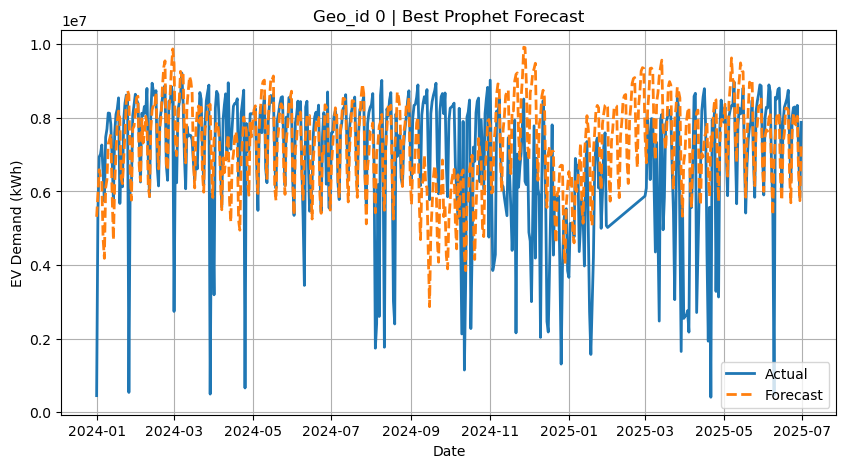

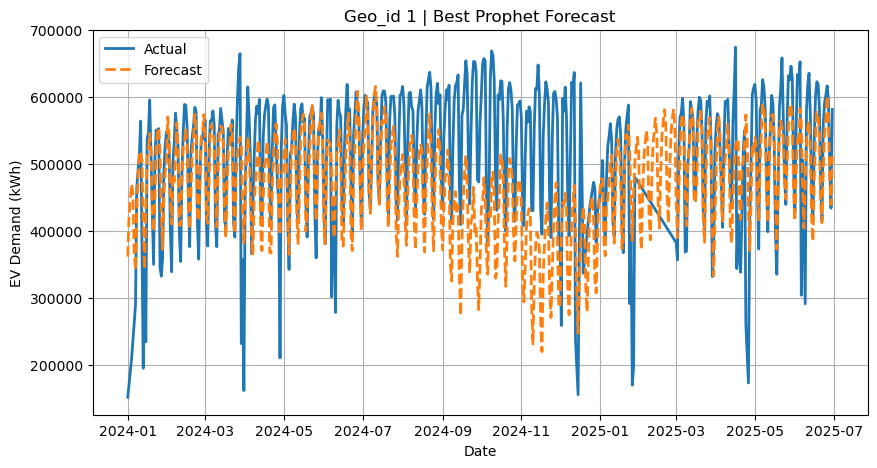

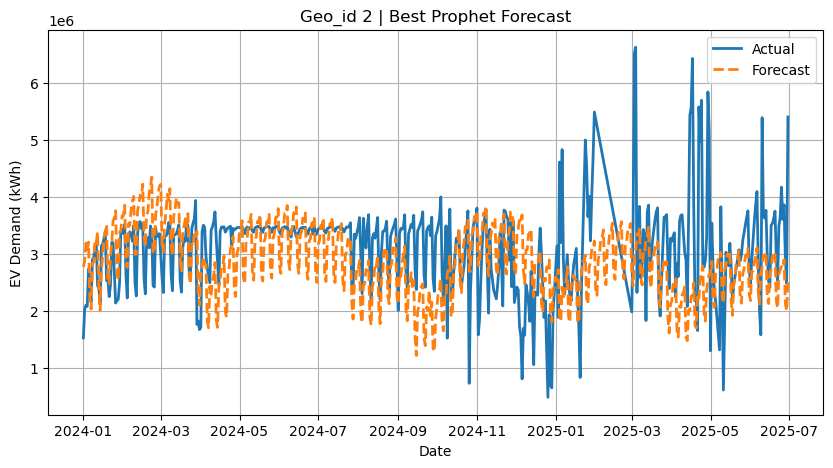

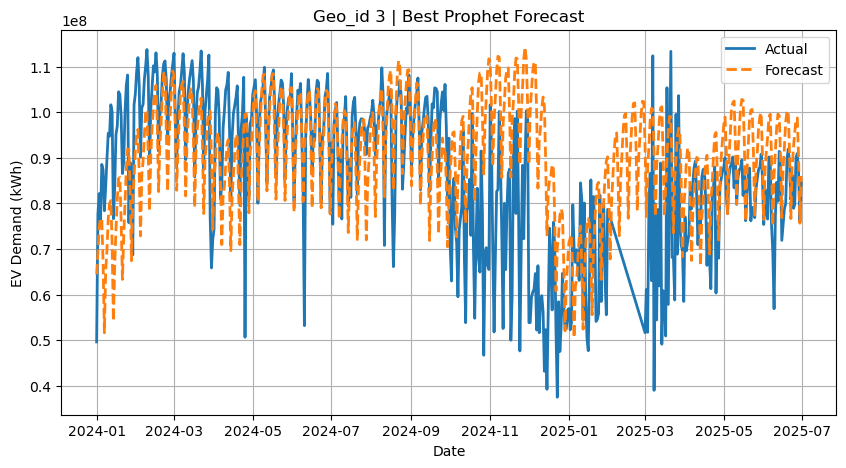

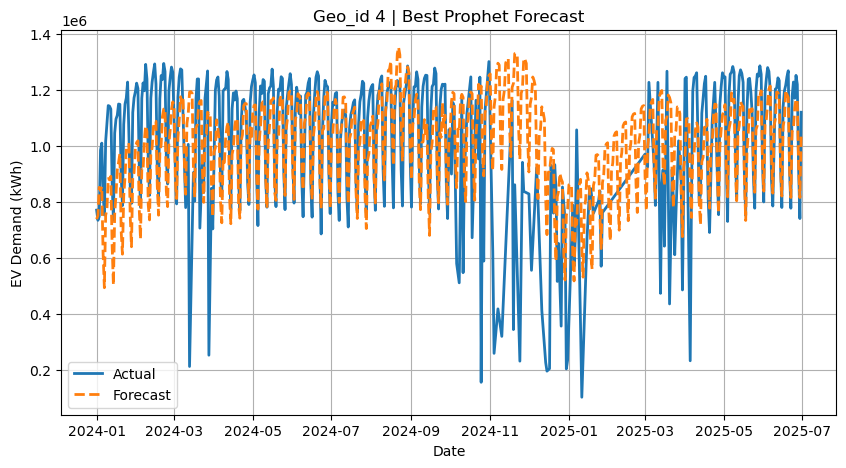

In [67]:
for geo_id, res in Prophet_model.items():
    plt.figure(figsize=(10,5))
    plt.plot(res["y_test"]['ds'], res["y_test"]['y'], label="Actual", linewidth=2)
    plt.plot(res["y_pred"]['ds'], res["y_pred"]['yhat'], label="Forecast", linestyle="--", linewidth=2)
    plt.title(f"Geo_id {geo_id} | Best Prophet Forecast")
    plt.xlabel("Date")
    plt.ylabel("EV Demand (kWh)")
    plt.legend()
    plt.grid(True)
    plt.show()


## Build Long Short-Term Memory (LSTM) Model for EV Charging Demand Prediction

In [84]:
LSTM_result ={}

for i in geo_number:
  df = geo_clean[geo_clean['geo_cluster'] == i]
  df = df.drop(columns=['geo_cluster'])

  # conver to datetime and set index to Date
  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date', inplace=True)

  #Split the trainning and testing dataset
  training_set, test_set = time_split(df, start, end)

  #Save the train
  training_set_shape = training_set.shape
  test_set_shape = test_set.shape

  #Import the min_max scaller
  sc = MinMaxScaler(feature_range =(0,1))

  #Reshape training_set
  training_set = training_set.values.reshape(-1,1)
  training_set_scaled = sc.fit_transform(training_set)
  training_set_scaled = training_set_scaled.reshape(training_set_shape[0], test_set_shape[1])

  #Parameter prepare for the model
  n_steps = 50
  forecasting_horizon = 14
  features = 7
  y_index = 0

  #Split the X_train and y_train for model
  X_train, y_train = split_sequence(training_set_scaled, n_steps, forecasting_horizon, y_index)

  #Reshaping Y_train for model
  y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

  #Set the gru_model
  model_lstm = Sequential()
  model_lstm.add(LSTM(units=128, activation="tanh", input_shape=(n_steps, features)))
  model_lstm.add(Dropout(0.2))
  model_lstm.add(Dense(units=forecasting_horizon))
  model_lstm.compile(optimizer="RMSprop", loss="mse")

  #Set the early stop
  model_lstm.fit(X_train, y_train, epochs=200, batch_size=64)

  #Set the RNN testing
  input_values = test_set.values.reshape(-1,1)
  input_values = sc.transform(input_values)
  input_values = input_values.reshape(test_set_shape[0], test_set_shape[1])

  #Split the X_test and y_test
  X_test, y_test = split_sequence(input_values, n_steps, forecasting_horizon, y_index)

  #Predict the values
  predict_EV_demand = model_lstm.predict(X_test)
  predict_EV_demand = sc.inverse_transform(predict_EV_demand)

  #Inverst the testing values
  y_test = y_test.reshape(y_test.shape[0],y_test.shape[1])
  y_test = sc.inverse_transform(y_test)


  LSTM_result[i] = {
      "model" : model_lstm,
      "predict_EV_demand": predict_EV_demand,
      "y_test" : y_test,
  }



Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.1400
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0580
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0521
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0488
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0441
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0434
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0416
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0409
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0401
Epoch 10/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0395
Epoch 11/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0381
Epoch 12/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0391
Epoch 13/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0375
Epoch 14/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0372
Epoch 15/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - lo

### Evaluate the model

In [85]:
best_LSTM_result = {}

for geo_id, res in LSTM_result.items():
    y_true = res["y_test"]
    y_pred = res["predict_EV_demand"]
    horizon = min(y_true.shape[1], y_pred.shape[1])

    # Initialize the best result for this geo_id
    best_for_geo = {
        "horizon": None,
        "mape": float("inf"),
        "mae": None,
        "rmse": None,
        "model": None,
        "y_test": None,
        "y_pred": None,
        "dates": None
    }

    print(f"\nGeo_id: {geo_id}")
    for i in range(horizon):
        mae, mape, rmse = return_metrics(y_true[:, i], y_pred[:, i])
        print(f"Horizon {i} | MAE={mae:.2f}, MAPE={mape:.2%}, RMSE={rmse:.2f}")

        # Update if MAPE is smaller than the current best for this geo_id
        if mape < best_for_geo["mape"]:
            best_for_geo = {
                "horizon": i,
                "mape": mape,
                "mae": mae,
                "rmse": rmse,
                "model": res["model"],
                "y_test": y_true[:, i],
                "y_pred": y_pred[:, i],
                "dates": res["y_test"]
            }

    # Save the best result for this geo_id
    best_LSTM_result[geo_id] = best_for_geo
    print("------------------")



Geo_id: 0
MAE: 1148999.89
MAPE: 33.70%
RMSE: 1592223.934225
Horizon 0 | MAE=1148999.89, MAPE=33.70%, RMSE=1592223.93
MAE: 1233444.05
MAPE: 35.98%
RMSE: 1678478.170750
Horizon 1 | MAE=1233444.05, MAPE=35.98%, RMSE=1678478.17
MAE: 1214704.71
MAPE: 36.36%
RMSE: 1687575.918240
Horizon 2 | MAE=1214704.71, MAPE=36.36%, RMSE=1687575.92
MAE: 1229455.80
MAPE: 36.33%
RMSE: 1691132.574801
Horizon 3 | MAE=1229455.80, MAPE=36.33%, RMSE=1691132.57
MAE: 1221353.45
MAPE: 36.27%
RMSE: 1682941.795725
Horizon 4 | MAE=1221353.45, MAPE=36.27%, RMSE=1682941.80
MAE: 1218093.62
MAPE: 36.03%
RMSE: 1669315.630438
Horizon 5 | MAE=1218093.62, MAPE=36.03%, RMSE=1669315.63
MAE: 1183191.62
MAPE: 35.71%
RMSE: 1664102.668616
Horizon 6 | MAE=1183191.62, MAPE=35.71%, RMSE=1664102.67
MAE: 1259509.06
MAPE: 36.09%
RMSE: 1703917.686624
Horizon 7 | MAE=1259509.06, MAPE=36.09%, RMSE=1703917.69
MAE: 1291290.19
MAPE: 36.58%
RMSE: 1733051.740101
Horizon 8 | MAE=1291290.19, MAPE=36.58%, RMSE=1733051.74
MAE: 1267320.44
MAPE: 36.3

In [86]:
print('LSTM Model')
print('------------------')
for geo_id, res in best_LSTM_result.items():
    y_true = res['y_test']
    y_test = res['y_pred']
    mean_val = y_true.mean()

    print(f"Geo_id: {geo_id}")
    print(f"Horizon: {res['horizon']}")
    print(f"MAPE: {res['mape']:.2%}")
    print(f"MAE:  {res['mae']:.2f}")
    print(f"RMSE: {res['rmse']:.2f}")
    print("------------------")


LSTM Model
------------------
Geo_id: 0
Horizon: 0
MAPE: 33.70%
MAE:  1148999.89
RMSE: 1592223.93
------------------
Geo_id: 1
Horizon: 0
MAPE: 11.05%
MAE:  46856.81
RMSE: 64619.99
------------------
Geo_id: 2
Horizon: 0
MAPE: 18.76%
MAE:  444864.50
RMSE: 676637.99
------------------
Geo_id: 3
Horizon: 0
MAPE: 11.13%
MAE:  7941826.59
RMSE: 11035380.13
------------------
Geo_id: 4
Horizon: 0
MAPE: 21.33%
MAE:  126560.15
RMSE: 178396.27
------------------


Plot the predicted and actual values

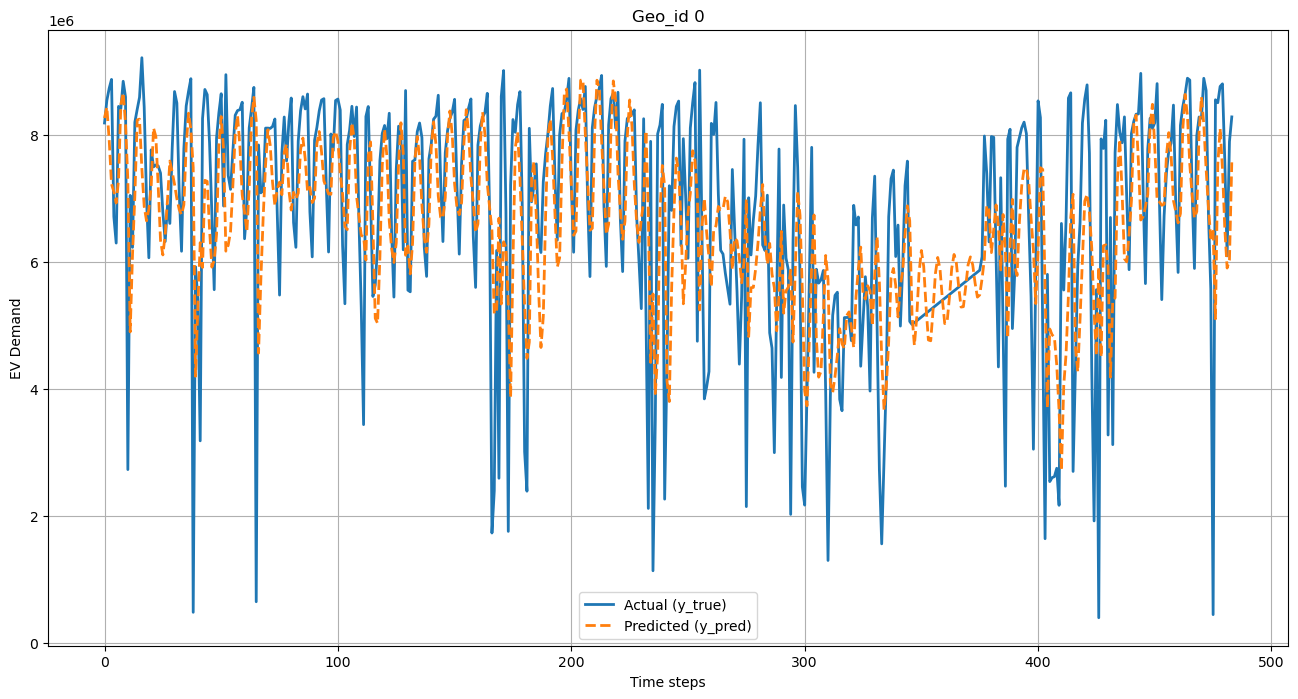

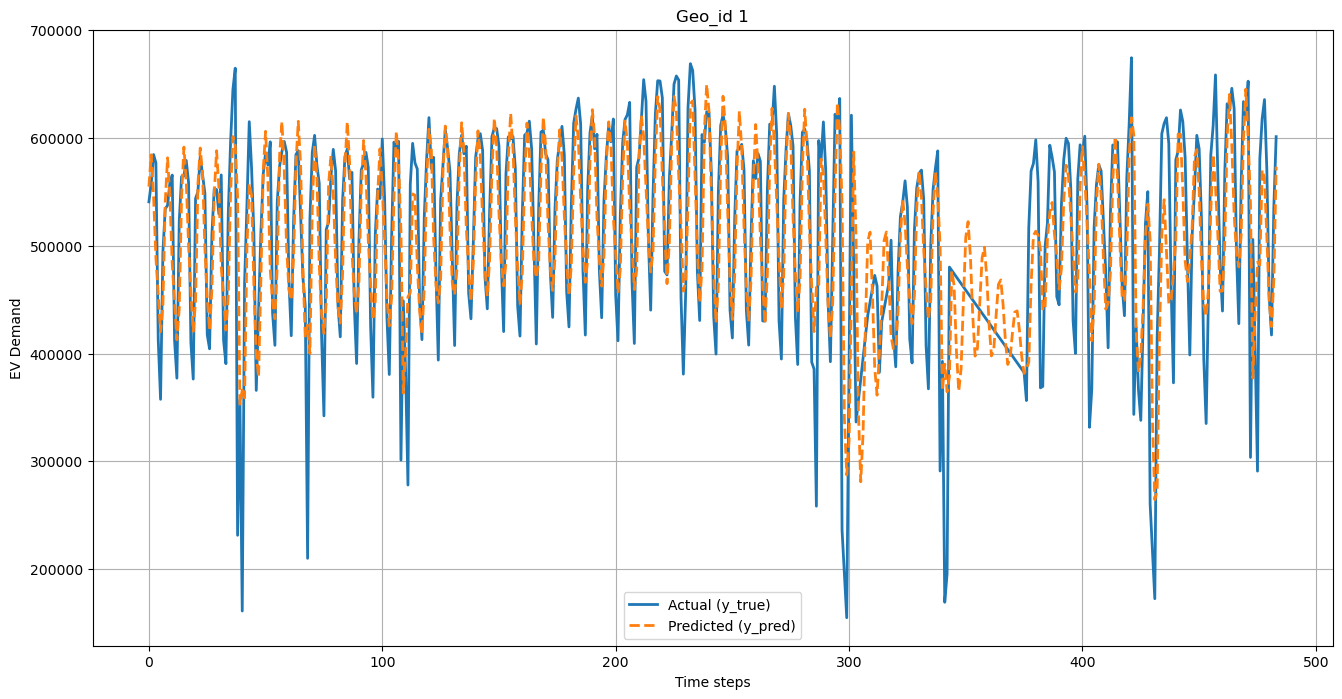

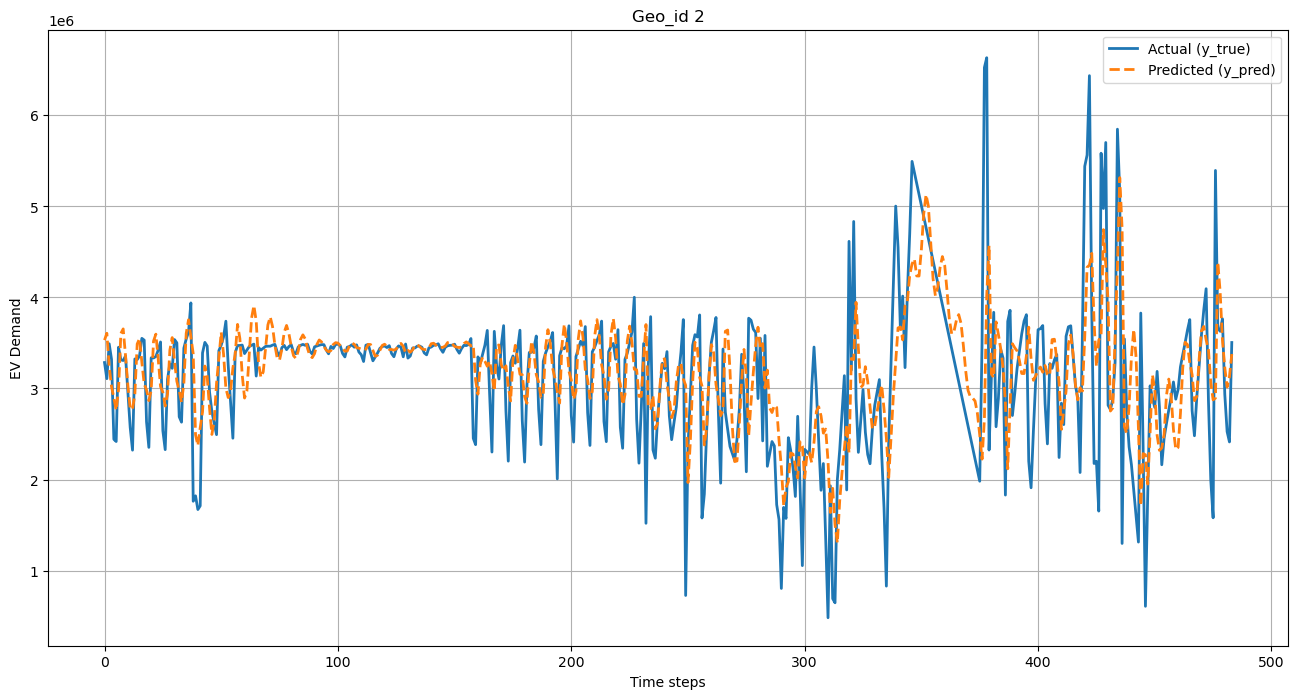

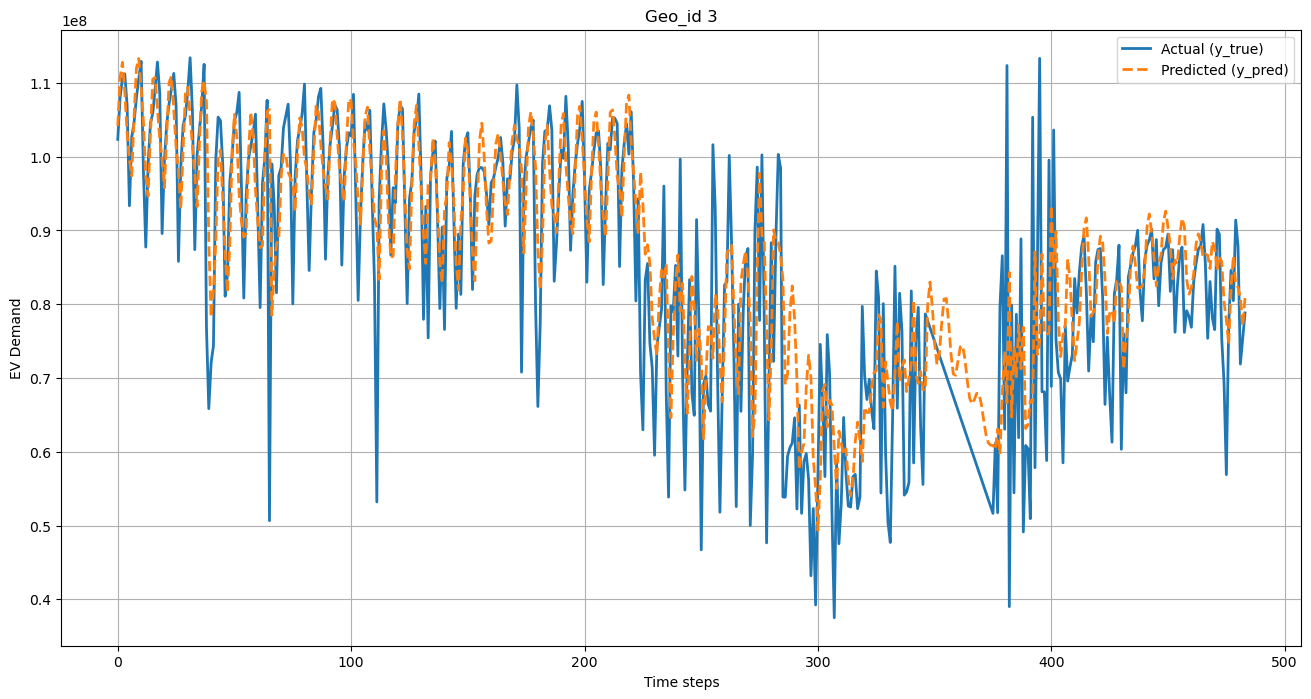

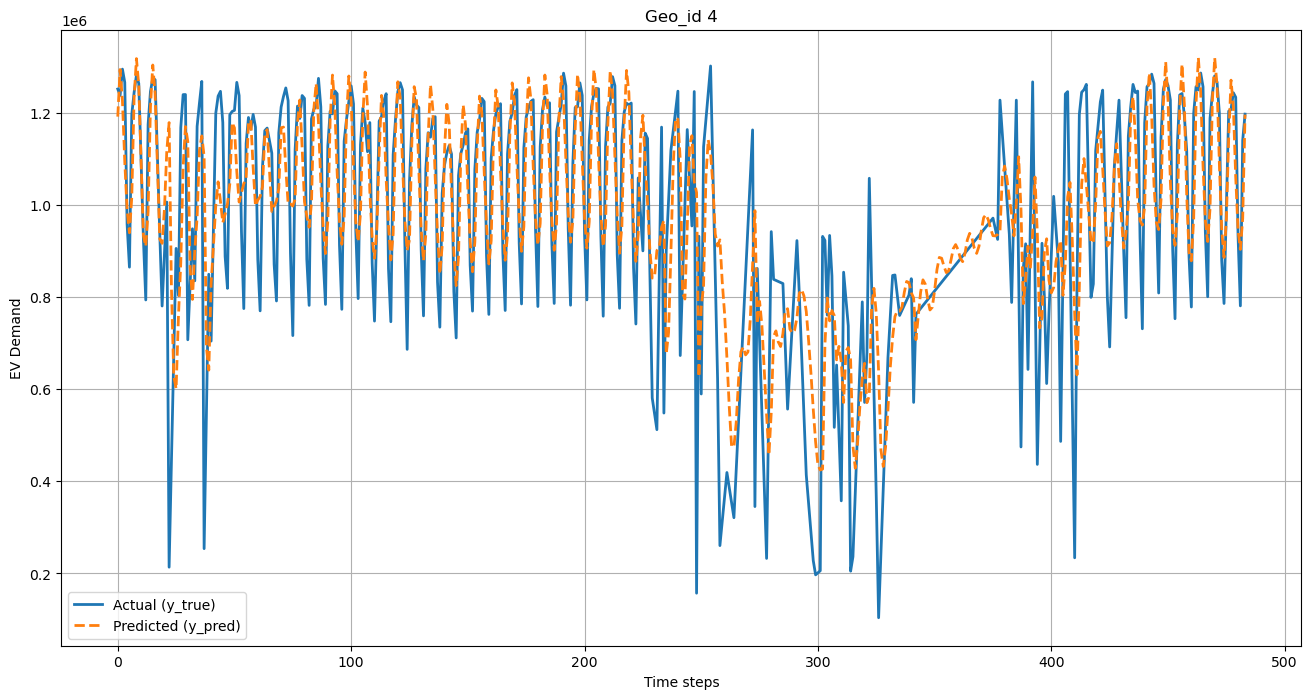

In [87]:
for geo_id, res in best_LSTM_result.items():
    plt.figure(figsize=(16, 8))
    plt.plot(res["y_test"], label="Actual (y_true)", linewidth=2)
    plt.plot(res["y_pred"], label="Predicted (y_pred)", linewidth=2, linestyle="--")
    plt.title(f"Geo_id {geo_id}")
    plt.xlabel("Time steps")
    plt.ylabel("EV Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

## Compare models and select the best for deployment

Print Mean Absolute Percentage Error (MAPE) results

In [88]:
# Print header row
print('Table 1: MAPE Result')
print(f"{'Geo_id':<7}{'LSTM':<12}{'Prophet':<15}{'SARIMA':<15}{'GRU':<12}")
print("-" * 65)

# Loop through Geo IDs
for geo_id in best_LSTM_result.keys():
    lstm_res = best_LSTM_result[geo_id]
    prop_res = Prophet_model[geo_id]
    sarima_res = SARIMA_model[geo_id]
    gru_res = best_GRU_result[geo_id]

    print(f"{geo_id:<7}"
          f"{lstm_res['mape']*100:<12.2f}"
          f"{prop_res['mape']*100:<15.2f}"
          f"{sarima_res['mape']*100:<15.2f}"
          f"{gru_res['mape']*100:<12.2f}")


Table 1: MAPE Result
Geo_id LSTM        Prophet        SARIMA         GRU         
-----------------------------------------------------------------
0      33.70       43.29          24.13          34.28       
1      11.05       16.95          58.99          10.86       
2      18.76       25.53          0.00           21.28       
3      11.13       18.69          0.79           10.90       
4      21.33       29.71          5.04           19.99       


Print Mean Absolute Error (MAE) results

In [91]:
# Print header row
print('Table 2: MAE Result')
print(f"{'Geo_id':<7}{'LSTM':<12}{'Prophet':<15}{'SARIMA':<15}{'GRU':<12}")
print("-" * 65)

# Loop through Geo IDs
for geo_id in best_LSTM_result.keys():
    lstm_res = best_LSTM_result[geo_id]
    prop_res = Prophet_model[geo_id]
    sarima_res = SARIMA_model[geo_id]
    gru_res = best_GRU_result[geo_id]

    print(f"{geo_id:<7}"
          f"{lstm_res['mae']:<12.2f}"
          f"{prop_res['mae']:<15.2f}"
          f"{sarima_res['mae']:<15.2f}"
          f"{gru_res['mae']:<12.2f}")


Table 2: MAE Result
Geo_id LSTM        Prophet        SARIMA         GRU         
-----------------------------------------------------------------
0      1148999.89  1330595.99     1132322.61     1085081.18  
1      46856.81    73825.34       283508.56      45146.96    
2      444864.50   699336.57      0.00           489681.97   
3      7941826.59  13077681.98    451241.66      7809498.86  
4      126560.15   168813.21      30405.09       121647.08   


Print Root Mean Square Error (RMSE) results

In [92]:
# Print header row
print('Table 3: RMSE Result')
print(f"{'Geo_id':<7}{'LSTM':<12}{'Prophet':<15}{'SARIMA':<15}{'GRU':<12}")
print("-" * 65)

# Loop through Geo IDs
for geo_id in best_LSTM_result.keys():
    lstm_res = best_LSTM_result[geo_id]
    prop_res = Prophet_model[geo_id]
    sarima_res = SARIMA_model[geo_id]
    gru_res = best_GRU_result[geo_id]

    print(f"{geo_id:<7}"
          f"{lstm_res['rmse']:<12.2f}"
          f"{prop_res['rmse']:<15.2f}"
          f"{sarima_res['rmse']:<15.2f}"
          f"{gru_res['rmse']:<12.2f}")


Table 3: RMSE Result
Geo_id LSTM        Prophet        SARIMA         GRU         
-----------------------------------------------------------------
0      1592223.93  1953033.92     1302280.86     1582290.08  
1      64619.99    97715.75       284055.56      63654.30    
2      676637.99   939968.08      0.00           704408.43   
3      11035380.13 17640440.99    2741305.24     10933330.79 
4      178396.27   250867.72      45492.82       173049.75   


The performance tables indicate that SARIMA consistently achieves very low error values (MAPE, MAE, RMSE) across most Geo_ids, in some cases outperforming the neural models. However, this apparent strength is misleading because SARIMA’s results are highly sensitive to how anomalies were handled during preprocessing. Since anomalies were removed or replaced before fitting, the model is effectively being trained on an overly “clean” dataset. This cause overfitting of SARIMA on the datasets (seeing the figure in the building SARIMA section), which could reduce robustness for real-world forecasting where demand volatility and anomalies are unavoidable.

In contrast, the GRU model shows consistently strong and stable performance across all Geo_ids, with lower sensitivity to anomalies when comparing the other three models, including LSTM and Prophet. Although its error metrics are slightly higher than SARIMA's on paper, they are more reliable because the model was evaluated under realistic conditions. GRU captures temporal dependencies flexibly and generalises better, making it a safer choice for long-term deployment. Additionally, most of the GRU model's performance achieves less than 20% of MAPE, which indicates that this model is excellent in predicting models.